# Телеком - отток клиентов

## Постановка задачи

Оператору связи необходимо научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

**Цель исследования**

Построить модель, оптимально предсказывающую вероятность оттока клиента с целью предотвращения его ухода и потери дохода.

**Ход исследования**

1. Предобработка и исследовательский анализ данных.

1.1. Обзор данных - загрузка данных и изучение их структуры, общей информации.

1.2. Предобработка данных - обьединение таблиц, обработка пропусков (заглушка скорей всего, тк клиенты могут использовать либо телефон, либо интернет, либо пользоваться обеими услугами - это тоже показатель для классификации клиентов), проверка на наличие ошибок, которые могут повлиять на результаты исследования, поиск возможности исправления наиболее критичных ошибок, оптимизация типа данных.

1.3. Проведение необходимых для исследовательского анализа расчетов дополнительных параметров, которые могут улучшить конечный результат обучения модели.

1.4. Проведение исследовательского и статистического анализа данных.

2. Построение и обучение модели. Тестирование. Подведение итогов по данному этапу.

2.1. Разбиение на выборки. Анализ данных на присутствие дисбаланса. Анализ влияния признаков на целевую переменную.

2.2. Выбор моделей для обучения исходя из имеющихся данных и проведенного исследования на предыдущем шаге.

2.3. Построение пайплана с подбором параметров.

2.4. Обучение моделей, получение валидационных метрик.

2.5. Анализ уровня метрик на валидации в разных моделях - f1-score/roc-auc/оптимальный порог классификации с учетом потребностей заказчика, выбор наиболее оптимальной модели с учетом времени обучения и уровня метрики.

2.6. Итоговое тестирование наилучшей модели.

3. Оформление выводов и результатов исследовательского проекта. Формулировка рекомендаций по подбору оптимального порога классификации клиентов.

**Дальнейшее применение**

Анализ альтернативных издержек: потери дохода в результате ухода клиента и затрат на его удержание.

## Обзор, предобработка и исследовательский анализ данных

### Обзор данных

Импорт необходимых библиотек

In [1]:
%pip install imbalanced-learn

In [2]:
!pip install catboost
!pip install phik
!pip install scikit-plot
!pip install sidetable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 6.3 MB/s eta 0:00:00


In [3]:
#импорты из стандартной библиотеки

import warnings

# библиотеки для работы с данными

from collections import Counter
from datetime import date
import numpy as np
import pandas as pd
import re
import sidetable

# библиотеки для визуализации

import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

# библиотеки для машинного обучения

from catboost import CatBoostClassifier
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    f1_score, precision_score, recall_score,
    mutual_info_score, precision_recall_curve
)
import sklearn.metrics as metrics
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
)
from sklearn.utils.class_weight import compute_class_weight

#настройки

pd.set_option('display.float_format', '{:,.2f}'.format) #формат вывода вещдественных чисел - 2 знака после запятой
warnings.filterwarnings("ignore")

# константы

LOAD_DATE = "2020-02-01"  # дата выгрузки датасета из базы
RANDOM_STATE = 12345


Определение списков имен файлов с данными, таблиц с данными и их имен для последующей работы в циклах. Загрузка данных.

In [4]:
! gdown --id 1Gc9O4SmWeljUAu2HrHhIfZjC83Y26KgT

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Gc9O4SmWeljUAu2HrHhIfZjC83Y26KgT
To: /content/telecom_data.zip
100% 303k/303k [00:00<00:00, 116MB/s]


In [5]:
! unzip /content/telecom_data.zip

Archive:  /content/telecom_data.zip
  inflating: contract.csv            
  inflating: internet.csv            
  inflating: personal.csv            
  inflating: phone.csv               


In [6]:
alternative_data_files = ['contract.csv', 'internet.csv', 'personal.csv', 'phone.csv']  # имена файлов с данными на локальном хранилище
data_files = [
    '/datasets/final_provider/contract.csv',
    '/datasets/final_provider/internet.csv',
    '/datasets/final_provider/personal.csv',
    '/datasets/final_provider/phone.csv'
]                                                                           # имена файлов с данными на сервере
df_data = []                                                                # таблицы с данными
df_names = ['df_contract', 'df_internet', 'df_personal', 'df_phone']        # имена таблиц с данными

In [7]:
for i in range(len(data_files)):
    try:
        df_data.append(pd.read_csv(data_files[i]))
        print('Файл', alternative_data_files[i], 'скачан с сервера')
    except:
        try:
            df_data.append(pd.read_csv(alternative_data_files[i]))
            print('Файл', alternative_data_files[i], 'скачан из локальной папки')
        except:
            print('Ошибка чтения файла', alternative_data_files[i])

Файл contract.csv скачан из локальной папки
Файл internet.csv скачан из локальной папки
Файл personal.csv скачан из локальной папки
Файл phone.csv скачан из локальной папки


Анализ размера таблиц, типов данных, наличия пропусков.

In [8]:
 for i in range(len(df_names)):
    print('Имя таблицы с данными:', df_names[i])
    print('Размер таблицы с данными:', df_data[i].shape, end='\n\n')
    print(df_data[i].info(), end='\n\n')

Имя таблицы с данными: df_contract
Размер таблицы с данными: (7043, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Имя таблицы с данными: df_internet
Размер таблицы с данными: (5517, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID       

In [9]:
for i in range(len(df_data)):
    print(df_names[i], end='\n\n')
    display(df_data[i].head(7))
    print('\n\n')

df_contract



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4





df_internet



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No





df_personal



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes





df_phone



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No


In [10]:
for i in range(len(df_data)):
    print(df_names[i], end='\n')
    display(df_data[i].describe(include = ['object', 'int64', 'float64']).T)
    print('\n')

df_contract


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,5,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,"7,043.00",NaN,NaN,NaN,64.76,30.09,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043,6531,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN




df_internet


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785




df_personal


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,"7,043.00",NaN,NaN,NaN,0.16,0.37,0.00,0.00,0.00,0.00,1.00
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN




df_phone


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


In [11]:
for i in range(len(df_data)):
    print()
    print(df_names[i], end='\n\n')
    for j in df_data[i].columns:
        if j not in ['customerID', 'BeginDate', 'EndDate', 'TotalCharges'] and j in df_data[i].select_dtypes('object').columns.tolist():
            df_data[i][j] = df_data[i][j].str.lower().str.strip()
            print(df_data[i][j].value_counts(), end='\n\n')


df_contract

month-to-month    3875
two year          1695
one year          1473
Name: Type, dtype: int64

yes    4171
no     2872
Name: PaperlessBilling, dtype: int64

electronic check             2365
mailed check                 1612
bank transfer (automatic)    1544
credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


df_internet

fiber optic    3096
dsl            2421
Name: InternetService, dtype: int64

no     3498
yes    2019
Name: OnlineSecurity, dtype: int64

no     3088
yes    2429
Name: OnlineBackup, dtype: int64

no     3095
yes    2422
Name: DeviceProtection, dtype: int64

no     3473
yes    2044
Name: TechSupport, dtype: int64

no     2810
yes    2707
Name: StreamingTV, dtype: int64

no     2785
yes    2732
Name: StreamingMovies, dtype: int64


df_personal

male      3555
female    3488
Name: gender, dtype: int64

no     3641
yes    3402
Name: Partner, dtype: int64

no     4933
yes    2110
Name: Dependents, dtype: int64


df_phone

no     3390
yes    2

В нашем распоряжении данные 4 таблиц df_personal (данные о клиентах), df_contract (данные о договорах), df_internet (данные о пользовании интернетом) и df_phone (данные о пользовании телефонией).

Столбцы таблиц содержат следующие данные:

* customerID - идентификатор клиента (тип object),
* gender - пол клиента (тип object, бинарный признак),
* SeniorCitizen - наличие пенсионного статуса по возрасту (тип int64, вероятней всего бинарный признак),
* Partner - наличие супруга(и) (тип object, бинарный признак),
* Dependents - наличие иждивенцев (тип object, бинарный признак),

* BeginDate - дата начала пользования услугами (тип object),
* EndDate - дата окончания пользования услугами (тип object),
* Type - тип оплаты: ежемесячный/годовой и тп (тип object),
* PaperlessBilling - безналичный расчет (тип object, бинарный признак),
* PaymentMethod - способ оплаты (тип object),
* MonthlyCharges - ежемесячные траты (тип float64),
* TotalCharges - всего потрачено денег на услуги (тип object),

* InternetService - тип подключения: DSL или оптоволокно (тип object),
* OnlineSecurity - наличие блокировки небезопасных сайтов (тип object, бинарный признак),
* DeviceProtection - наличие антивируса (тип object, бинарный признак),
* OnlineBackup - наличие облачного хранилища для резервного копирования данных (тип object, бинарный признак),
* TechSupport - наличие выделенной линии технической поддержки (тип object, бинарный признак),
* StreamingTV - наличие стримингового телевидения (тип object, бинарный признак),
* StreamingMovies - наличие каталога фильмов (тип object, бинарный признак),

* MultipleLines - возможность подключения телефонного аппарата к нескольким линиям одновременно (тип object, бинарный признак)


Проверим наличие пропусков.

In [12]:
for i in range(len(df_data)):
    print(df_names[i], end='\n')
    display(df_data[i].stb.missing())
    print('\n')

df_contract


,missing,total,percent
customerID,0,7043,0.00
BeginDate,0,7043,0.00
EndDate,0,7043,0.00
Type,0,7043,0.00
PaperlessBilling,0,7043,0.00
PaymentMethod,0,7043,0.00
MonthlyCharges,0,7043,0.00
TotalCharges,0,7043,0.00




df_internet


,missing,total,percent
customerID,0,5517,0.00
InternetService,0,5517,0.00
OnlineSecurity,0,5517,0.00
OnlineBackup,0,5517,0.00
DeviceProtection,0,5517,0.00
TechSupport,0,5517,0.00
StreamingTV,0,5517,0.00
StreamingMovies,0,5517,0.00




df_personal


,missing,total,percent
customerID,0,7043,0.00
gender,0,7043,0.00
SeniorCitizen,0,7043,0.00
Partner,0,7043,0.00
Dependents,0,7043,0.00




df_phone


,missing,total,percent
customerID,0,6361,0.00
MultipleLines,0,6361,0.00


Таблицы содержат данные о 7043 клиентах. Пропусков в данных нет.
Причем интернетом пользуются 5517 клиентов, телефоном - 6361 клиент. Не все клиенты позуются двумя типами услуг. В диаграмме Эйлера-Венна ниже отражено соотношение клиентов по типу услуг.
На этапе дальнейшего объединения таблиц необходимо будет предусмотреть наличие технологических пропусков и записать данные об отсутствии у клиента той или иной услуги.

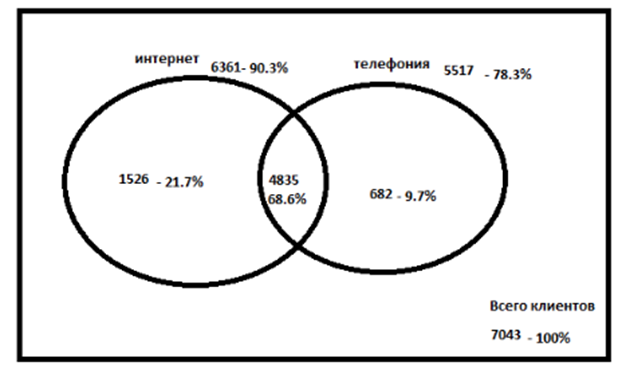

### Предобработка данных, генерация признаков

Проведем предварительную предобработку данных:
 - приведем названия столбцов в змеиный регистр
 - избавимся от неявных дубликатов в столбцах типа object
 - данные в столбце SeniorCitizen приведем к типу object (yes/no) с целью унификации отображения бинарных данных
 - приведем числовые данные в столбце TotalCharges к типу float64, данные о дате BeginDate и EndDate - к типу даты
 - сгенерируем новые признаки - целевой признак churn из данных столбца end_date (где проставлена дата окончания договорных отношений) и количество месяцев пользования услугами компании month_count как разница между end_date и begin_date (в случае продолжения пользования услугами проставляем в столбце end_date текущую дату)

Приведем названия столбцов к змеиному регистру.

In [13]:
# функция приведения названия столбца к змеиному регистру

def column_rename(col_name):
    col_name_chars = list(col_name)
    [col_name_chars.insert(x,'_') for x in [m.start() for m in re.finditer("[A-Z]",col_name)][:0:-1]]
    new_col_name = ''.join(col_name_chars).lower()
    return new_col_name

In [14]:
for i in range(len(df_data)):
    arr_col_names = []
    print(df_names[i], end='\n')
    print(list(df_data[i].columns))
    for j in list(df_data[i].columns):
        if j=='customerID':
            arr_col_names.append('customer_id')
        elif j=='StreamingTV':
            arr_col_names.append('streaming_tv')
        else:
            arr_col_names.append(column_rename(j))
    df_data[i].columns = arr_col_names
    print(list(df_data[i].columns))
    print('\n')

df_contract
['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']


df_internet
['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']


df_personal
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']


df_phone
['customerID', 'MultipleLines']
['customer_id', 'multiple_lines']




Обработаем неявные дубликаты. Для этого данные в столбцах таблиц с типом object, кроме customer_id, приведем к нижнему регистру и удалим лишние пробелы.

In [15]:
for i in range(len(df_data)):
    df_tmp = df_data[i].select_dtypes('object')
    for j in df_tmp.columns:
        if j!='customer_id':
            df_tmp[j] = df_tmp[j].str.lower().str.strip()

Данные в столбце SeniorCitizen приведем к типу object (yes/no) с целью унификации отображения бинарных данных.

In [16]:
df_data[2]['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

In [17]:
df_data[2]['senior_citizen'] = df_data[2]['senior_citizen'].replace({0: 'no', 1: 'yes'})
df_data[2]['senior_citizen'].value_counts()

no     5901
yes    1142
Name: senior_citizen, dtype: int64

Перед работой с данными в столбце end_date сгенерируем целевой признак churn.

In [18]:
df_data[0]['churn'] = 1 * (df_data[0]['end_date'] != 'No')
df_data[0].head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,No,month-to-month,yes,electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,one year,no,mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,one year,no,bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,1


In [19]:
df_data[0]['churn'].value_counts(normalize=True)

0   0.73
1   0.27
Name: churn, dtype: float64

Наблюдается дисбаланс классов. Соотношение 73,5% лояльных клиентов к 26,5% ушедшим клиентам. Метрика ROC-AUC не чувствительна к дисбалансу, accuracy и F1-мера чувствительны.  

Заполним данные в столбце end_date по лояльным (оставшимся) клиентам датой выгрузки датасета из базы - константа задана в блоке загрузки необходимых библиотек.

In [20]:
df_data[0]['end_date'] = df_data[0]['end_date'].where(df_data[0]['end_date'] != 'No', LOAD_DATE)
df_data[0].head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,one year,no,mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,1


Приведем типы данных в столбцах begin_date и end_date к типу даты.

In [21]:
df_data[0]['begin_date'] = df_data[0].begin_date.apply(pd.to_datetime, format='%Y-%m-%d')
df_data[0]['end_date'] = df_data[0].query(
    'end_date != "No"'
).end_date.apply(
    pd.to_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce'
)

In [22]:
df_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   churn              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Приведем числовые данные в столбце total_charges к типу float64. На случай возникновения ошибки при преобразовании типов данных с целью дальнейшего анализа создадим новый столбец total_charges_fl, который и будем подвергать обработке типа данных. Используем метод to_numeric из библиотеки pandas. В случае невозможности перевести строку в число, в соответствующее значение будет записан пропуск - Nan.

In [23]:
df_data[0]['total_charges_fl'] = df_data[0]['total_charges']

In [24]:
df_data[0]['total_charges_fl'].value_counts().head()

         11
20.2     11
19.75     9
20.05     8
19.9      8
Name: total_charges_fl, dtype: int64

In [25]:
df_data[0].query('total_charges_fl == " "').total_charges_fl.count()

11

Пустые значения в столбце total_charges_fl содержатся в 11 строках.

In [26]:
df_data[0]['total_charges_fl'] = df_data[0].total_charges_fl.apply(pd.to_numeric, errors='coerce', downcast='float')

In [27]:
display(df_data[0].dtypes)
display(df_data[0].stb.missing())

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges                object
churn                         int64
total_charges_fl            float32
dtype: object

,missing,total,percent
total_charges_fl,11,7043,0.16
customer_id,0,7043,0.00
begin_date,0,7043,0.00
end_date,0,7043,0.00
type,0,7043,0.00
paperless_billing,0,7043,0.00
payment_method,0,7043,0.00
monthly_charges,0,7043,0.00
total_charges,0,7043,0.00
churn,0,7043,0.00


Всего получилось 11 таких строк. Выведем их на экран.

In [28]:
display(df_data[0].query('total_charges_fl != total_charges_fl'))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_charges_fl
488,4472-LVYGI,2020-02-01,2020-02-01,two year,yes,bank transfer (automatic),52.55,,0,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,two year,no,mailed check,20.25,,0,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,two year,no,mailed check,80.85,,0,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,two year,no,mailed check,25.75,,0,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,two year,no,credit card (automatic),56.05,,0,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,two year,no,mailed check,19.85,,0,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,two year,no,mailed check,25.35,,0,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,two year,no,mailed check,20.00,,0,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,one year,yes,mailed check,19.70,,0,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,two year,no,mailed check,73.35,,0,NaN


Тк в столбце begin_date дата максимальная '2020-02-01', следовательно клиент только начал пользоваться услугами и не прошло еще месяца с момента регистрации договора, поэтому сумма в столбце total_charges пустая. Чтобы не терять данные по другим признакам заполним данные столбце значением из monthly_charges.

In [29]:
df_data[0]['total_charges_fl'] = df_data[0]['total_charges_fl'].fillna(df_data[0]['monthly_charges'])

In [30]:
display(df_data[0].query('total_charges == " "'))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_charges_fl
488,4472-LVYGI,2020-02-01,2020-02-01,two year,yes,bank transfer (automatic),52.55,,0,52.55
753,3115-CZMZD,2020-02-01,2020-02-01,two year,no,mailed check,20.25,,0,20.25
936,5709-LVOEQ,2020-02-01,2020-02-01,two year,no,mailed check,80.85,,0,80.85
1082,4367-NUYAO,2020-02-01,2020-02-01,two year,no,mailed check,25.75,,0,25.75
1340,1371-DWPAZ,2020-02-01,2020-02-01,two year,no,credit card (automatic),56.05,,0,56.05
3331,7644-OMVMY,2020-02-01,2020-02-01,two year,no,mailed check,19.85,,0,19.85
3826,3213-VVOLG,2020-02-01,2020-02-01,two year,no,mailed check,25.35,,0,25.35
4380,2520-SGTTA,2020-02-01,2020-02-01,two year,no,mailed check,20.00,,0,20.00
5218,2923-ARZLG,2020-02-01,2020-02-01,one year,yes,mailed check,19.70,,0,19.70
6670,4075-WKNIU,2020-02-01,2020-02-01,two year,no,mailed check,73.35,,0,73.35


Удалим столбец total_charges с пустыми значениями и переименуем total_charges_fl в total_charges.

In [31]:
df_data[0] = df_data[0].drop('total_charges', axis=1)

In [32]:
df_data[0] = df_data[0].rename(columns ={'total_charges_fl': 'total_charges'})

Сгенерируем признак количество месяцев пользования услугами.

In [33]:
df_data[0]['month_count'] = df_data[0]['end_date'].dt.to_period('M').astype(int) \
- df_data[0]['begin_date'].dt.to_period('M').astype(int)
df_data[0]['day_count'] = df_data[0]['end_date'].dt.to_period('D').astype(int) \
- df_data[0]['begin_date'].dt.to_period('D').astype(int)
df_data[0].head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,churn,total_charges,month_count,day_count
0,7590-VHVEG,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,0,29.85,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,one year,no,mailed check,56.95,0,"1,889.50",34,1036
2,3668-QPYBK,2019-10-01,2019-12-01,month-to-month,yes,mailed check,53.85,1,108.15,2,61
3,7795-CFOCW,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,0,"1,840.75",45,1371
4,9237-HQITU,2019-09-01,2019-11-01,month-to-month,yes,electronic check,70.70,1,151.65,2,61
5,9305-CDSKC,2019-03-01,2019-11-01,month-to-month,yes,electronic check,99.65,1,820.50,8,245
6,1452-KIOVK,2018-04-01,2020-02-01,month-to-month,yes,credit card (automatic),89.10,0,"1,949.40",22,671
7,6713-OKOMC,2019-04-01,2020-02-01,month-to-month,no,mailed check,29.75,0,301.90,10,306
8,7892-POOKP,2017-07-01,2019-11-01,month-to-month,yes,electronic check,104.80,1,"3,046.05",28,853
9,6388-TABGU,2014-12-01,2020-02-01,one year,no,bank transfer (automatic),56.15,0,"3,487.95",62,1888


Обьединим таблицы в одну. Сначала убедимся в отсутствии пропусков

In [34]:
for i in range(len(df_data)):
    print(df_names[i], end='\n')
    display(df_data[i].stb.missing())
    print('\n')

df_contract


,missing,total,percent
customer_id,0,7043,0.00
begin_date,0,7043,0.00
end_date,0,7043,0.00
type,0,7043,0.00
paperless_billing,0,7043,0.00
payment_method,0,7043,0.00
monthly_charges,0,7043,0.00
churn,0,7043,0.00
total_charges,0,7043,0.00
month_count,0,7043,0.00




df_internet


,missing,total,percent
customer_id,0,5517,0.00
internet_service,0,5517,0.00
online_security,0,5517,0.00
online_backup,0,5517,0.00
device_protection,0,5517,0.00
tech_support,0,5517,0.00
streaming_tv,0,5517,0.00
streaming_movies,0,5517,0.00




df_personal


,missing,total,percent
customer_id,0,7043,0.00
gender,0,7043,0.00
senior_citizen,0,7043,0.00
partner,0,7043,0.00
dependents,0,7043,0.00




df_phone


,missing,total,percent
customer_id,0,6361,0.00
multiple_lines,0,6361,0.00


In [35]:
df_full = df_data[0].merge(
    df_data[2], on='customer_id', how='left'
).merge(
    df_data[1], on='customer_id', how='left'
).merge(df_data[3], on='customer_id', how='left')
df_full.head(10).T

,0,1,2,3,4,5,6,7,8,9
customer_id,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU
begin_date,2020-01-01 00:00:00,2017-04-01 00:00:00,2019-10-01 00:00:00,2016-05-01 00:00:00,2019-09-01 00:00:00,2019-03-01 00:00:00,2018-04-01 00:00:00,2019-04-01 00:00:00,2017-07-01 00:00:00,2014-12-01 00:00:00
end_date,2020-02-01 00:00:00,2020-02-01 00:00:00,2019-12-01 00:00:00,2020-02-01 00:00:00,2019-11-01 00:00:00,2019-11-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2019-11-01 00:00:00,2020-02-01 00:00:00
type,month-to-month,one year,month-to-month,one year,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,one year
paperless_billing,yes,no,yes,no,yes,yes,yes,no,yes,no
payment_method,electronic check,mailed check,mailed check,bank transfer (automatic),electronic check,electronic check,credit card (automatic),mailed check,electronic check,bank transfer (automatic)
monthly_charges,29.85,56.95,53.85,42.30,70.70,99.65,89.10,29.75,104.80,56.15
churn,0,0,1,0,1,1,0,0,1,0
total_charges,29.85,"1,889.50",108.15,"1,840.75",151.65,820.50,"1,949.40",301.90,"3,046.05","3,487.95"
month_count,1,34,2,45,2,8,22,10,28,62


In [36]:
df_full.stb.missing()

,missing,total,percent
streaming_movies,1526,7043,21.67
streaming_tv,1526,7043,21.67
tech_support,1526,7043,21.67
device_protection,1526,7043,21.67
online_backup,1526,7043,21.67
online_security,1526,7043,21.67
internet_service,1526,7043,21.67
multiple_lines,682,7043,9.68
senior_citizen,0,7043,0.00
dependents,0,7043,0.00


Видим наличие пропусков. Они технологические - означают, что некоторые клиенты не пользуются услугами интернета или телефона. Добавим новый признак - какими услугами пользуется клиент: internet - только интернетом, phone - только телефоном, both - обеими.

In [37]:
df_full = df_full.fillna('-')

Занесем данные о предоставляемых клиенту услугах в столбец service: internet, phone или both.

In [138]:
df_full['service'] = df_full['multiple_lines'].apply(lambda x: 'internet' if x=='-' else '')
df_full.loc[df_full['service'] == '', 'service'] = df_full['streaming_movies'].apply(
    lambda y: 'phone' if y=='-' else 'both')

In [39]:
df_full.head(7).T

,0,1,2,3,4,5,6
customer_id,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
begin_date,2020-01-01 00:00:00,2017-04-01 00:00:00,2019-10-01 00:00:00,2016-05-01 00:00:00,2019-09-01 00:00:00,2019-03-01 00:00:00,2018-04-01 00:00:00
end_date,2020-02-01 00:00:00,2020-02-01 00:00:00,2019-12-01 00:00:00,2020-02-01 00:00:00,2019-11-01 00:00:00,2019-11-01 00:00:00,2020-02-01 00:00:00
type,month-to-month,one year,month-to-month,one year,month-to-month,month-to-month,month-to-month
paperless_billing,yes,no,yes,no,yes,yes,yes
payment_method,electronic check,mailed check,mailed check,bank transfer (automatic),electronic check,electronic check,credit card (automatic)
monthly_charges,29.85,56.95,53.85,42.30,70.70,99.65,89.10
churn,0,0,1,0,1,1,0
total_charges,29.85,"1,889.50",108.15,"1,840.75",151.65,820.50,"1,949.40"
month_count,1,34,2,45,2,8,22


Заполним прочерки '-' значениями 'no' в бинарных признаках.

In [40]:
internet_phone_columns = [
    'internet_service','online_security','online_backup',
    'device_protection','tech_support','streaming_tv','streaming_movies',
    'multiple_lines'
]

df_full[internet_phone_columns] = df_full[internet_phone_columns].replace({'-': 'no'})


In [41]:
df_full.head(7).T

,0,1,2,3,4,5,6
customer_id,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK
begin_date,2020-01-01 00:00:00,2017-04-01 00:00:00,2019-10-01 00:00:00,2016-05-01 00:00:00,2019-09-01 00:00:00,2019-03-01 00:00:00,2018-04-01 00:00:00
end_date,2020-02-01 00:00:00,2020-02-01 00:00:00,2019-12-01 00:00:00,2020-02-01 00:00:00,2019-11-01 00:00:00,2019-11-01 00:00:00,2020-02-01 00:00:00
type,month-to-month,one year,month-to-month,one year,month-to-month,month-to-month,month-to-month
paperless_billing,yes,no,yes,no,yes,yes,yes
payment_method,electronic check,mailed check,mailed check,bank transfer (automatic),electronic check,electronic check,credit card (automatic)
monthly_charges,29.85,56.95,53.85,42.30,70.70,99.65,89.10
churn,0,0,1,0,1,1,0
total_charges,29.85,"1,889.50",108.15,"1,840.75",151.65,820.50,"1,949.40"
month_count,1,34,2,45,2,8,22


In [42]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   churn              7043 non-null   int64         
 8   total_charges      7043 non-null   float64       
 9   month_count        7043 non-null   int64         
 10  day_count          7043 non-null   int64         
 11  gender             7043 non-null   object        
 12  senior_citizen     7043 non-null   object        
 13  partner            7043 non-null   object        
 14  dependen

Проверим данные на наличие полных дубликатов.

In [43]:
print('Количество полных дубликатов в таблице', df_full.duplicated().sum())

Количество полных дубликатов в таблице 0


### Исследовательский и статистический анализ

In [44]:
df_full.describe(include = ['datetime64']).T

,count,unique,top,freq,first,last
begin_date,7043,77,2014-02-01,366,2013-10-01,2020-02-01
end_date,7043,5,2020-02-01,5174,2019-10-01,2020-02-01


Предоставлены данные за период с 2013-10-01 по 2020-02-01 (по времени begin_date). Уход клиентов с 2019-10-01. Посмотрим подробнее распределение данных по датам и числовым данным.

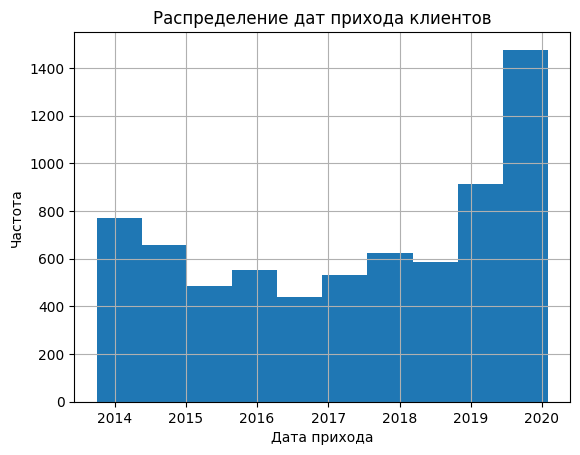

In [45]:
df_full.begin_date.hist()
plt.title('Распределение дат прихода клиентов')
plt.xlabel('Дата прихода')
plt.ylabel('Частота')
plt.show()

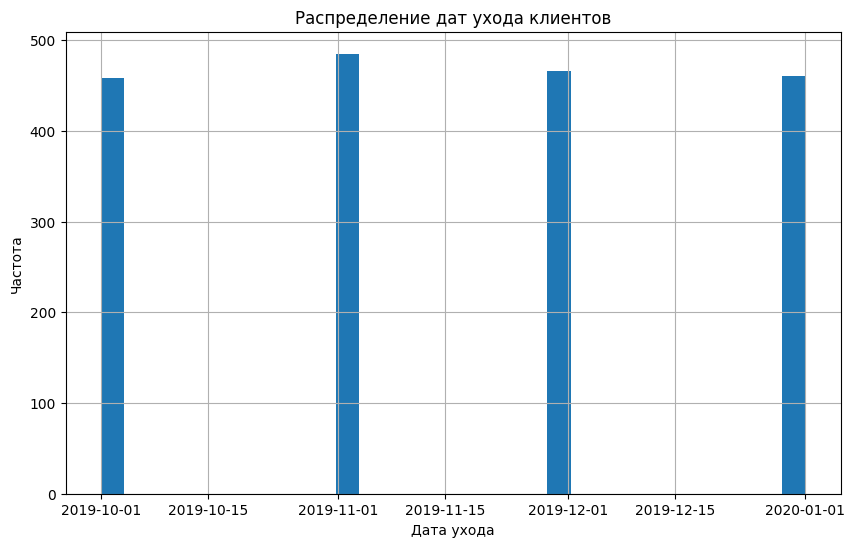

In [46]:
plt.figure(figsize=(10,6))
df_full.query('end_date != @LOAD_DATE').end_date.hist(bins=30)
plt.title('Распределение дат ухода клиентов')
plt.xlabel('Дата ухода')
plt.ylabel('Частота')
plt.show()

Данные об уходе клиентов из компании заносятся ежемесячно в первое число месяца партиями около 500 человек, начиная с октября 2019. Последняя дата занесения данных об ушедших клиентах 01 января 2020г. В феврале данные еще не были занесены.

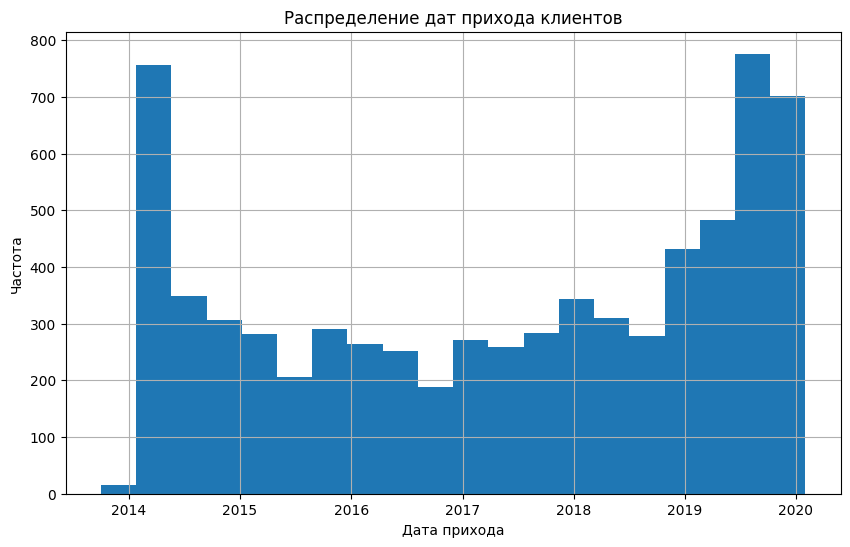

In [47]:
plt.figure(figsize=(10,6))
df_full['begin_date'].hist(bins=20)
plt.title('Распределение дат прихода клиентов')
plt.xlabel('Дата прихода')
plt.ylabel('Частота')
plt.show()

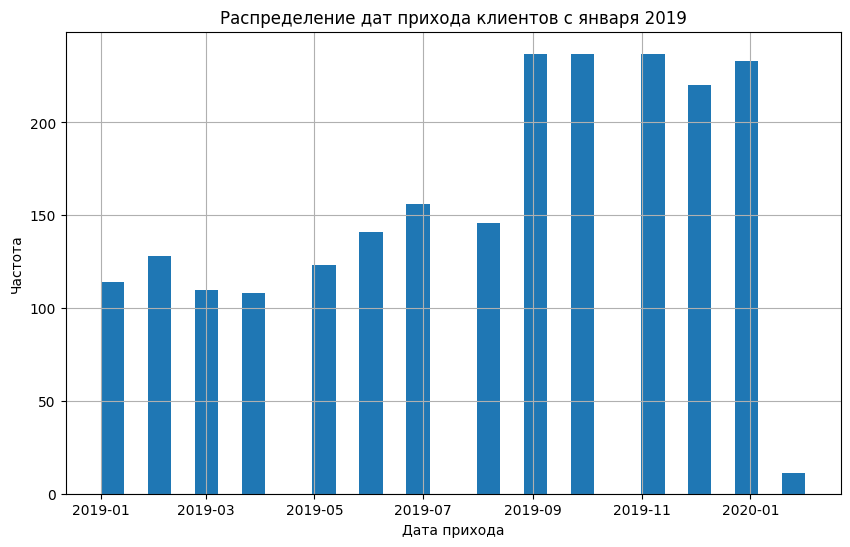

In [48]:
plt.figure(figsize=(10,6))
df_data[0].query('begin_date >= "2019-01-01"').begin_date.hist(bins=30)
plt.title('Распределение дат прихода клиентов с января 2019')
plt.xlabel('Дата прихода')
plt.ylabel('Частота')
plt.show()

Приход клиентов в первые даты был значительным. Скорей всего связано с занесением ранее пришедших клиентов в введенную в эксплуатацию базу данных. Затем равномерное распределение и рост прихода клиентов в период с сентября 2019года (возможно, связано с проведением рекламной кампании и внедрением новой услуги-тарифа).

Распределение ежемесячной суммы оплат клиентов


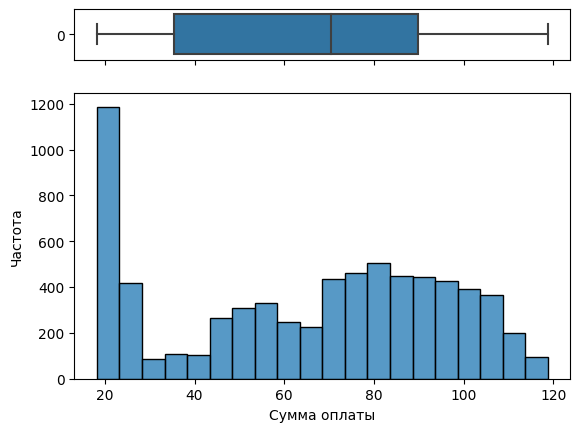

In [49]:
print('Распределение ежемесячной суммы оплат клиентов')
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
sns.boxplot(df_full['monthly_charges'], ax=ax_box, orient='h')
sns.histplot(data=df_full, x='monthly_charges', ax=ax_hist, bins=20)
plt.xlabel('Сумма оплаты')
plt.ylabel('Частота')
plt.show()

Имеем мультимодальное распределение. Возможно это связано с разными тарифами компании (в районе 20, 50 и 80). Для целей обучения возможно необходимо будет выделить признак принадлежности к тарифу, тогда распределение признака внутри группы приобретет нормальный вид.

Распределение общей суммы оплат клиентов


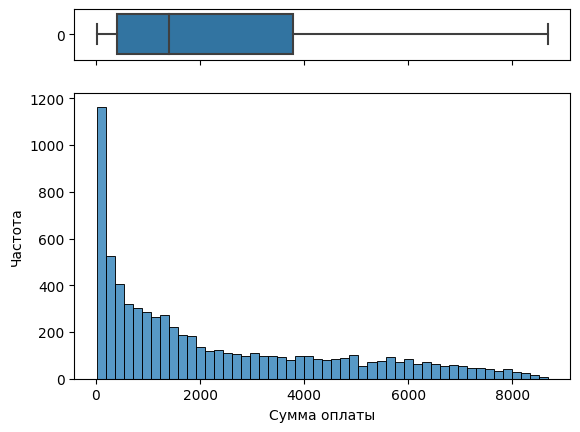

In [50]:
print('Распределение общей суммы оплат клиентов')
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
sns.boxplot(df_full['total_charges'], ax=ax_box, orient='h')
sns.histplot(data=df_full, x='total_charges', ax=ax_hist, bins=50)
plt.xlabel('Сумма оплаты')
plt.xticks()
plt.ylabel('Частота')
plt.show()

Перед нами long-tail распределение, сильно смещено влево. Это говорит о том, что достаточно много клиентов с низкими платежами. Это клиенты либо пришедшие недавно в компанию, либо долгосрочные клиенты с низким тарифом.   

In [51]:
tariffs_lim = [50, 100, 200, 900]

In [52]:
print('Количество ушедших клиентов с общей выручкой до 50:', '\n',
      df_full.query('total_charges <= @tariffs_lim[0]').churn.value_counts(), '\n',
      df_full.query('total_charges <= @tariffs_lim[0]').churn.value_counts(normalize=True)
      )
print('Количество ушедших клиентов с общей выручкой от 50 до 100:', '\n',
      df_full.query('@tariffs_lim[0] < total_charges <= @tariffs_lim[1]').churn.value_counts(), '\n',
      df_full.query('@tariffs_lim[0] < total_charges <= @tariffs_lim[1]').churn.value_counts(normalize=True)
      )
print('Количество ушедших клиентов с общей выручкой от 100 до 200:', '\n',
      df_full.query('@tariffs_lim[1] < total_charges <= @tariffs_lim[2]').churn.value_counts(), '\n',
      df_full.query('@tariffs_lim[1] < total_charges <= @tariffs_lim[2]').churn.value_counts(normalize=True)
      )
print('Количество ушедших клиентов с общей выручкой от 200 до 900:', '\n',
      df_full.query('@tariffs_lim[2] < total_charges <= @tariffs_lim[3]').churn.value_counts(), '\n',
      df_full.query('@tariffs_lim[2] < total_charges <= @tariffs_lim[3]').churn.value_counts(normalize=True)
      )

Количество ушедших клиентов с общей выручкой до 50: 
 0    221
1    150
Name: churn, dtype: int64 
 0   0.60
1   0.40
Name: churn, dtype: float64
Количество ушедших клиентов с общей выручкой от 50 до 100: 
 1    281
0    172
Name: churn, dtype: int64 
 1   0.62
0   0.38
Name: churn, dtype: float64
Количество ушедших клиентов с общей выручкой от 100 до 200: 
 0    225
1    143
Name: churn, dtype: int64 
 0   0.61
1   0.39
Name: churn, dtype: float64
Количество ушедших клиентов с общей выручкой от 200 до 900: 
 0    1093
1     458
Name: churn, dtype: int64 
 0   0.70
1   0.30
Name: churn, dtype: float64


По данным можно сделать вывод: с общей выручкой от 50 до 100 ушли 62% клиентов. Возможно, это связано с тарифом клиентов

Проанализируем показатель срока сотрудничества клиентов. Для целей исследовательского анализа возьмем более укрупненный показатель - количество месяцев сотрудничества. для построения модели прогнозирования лучше взять более точный показатель - количество дней сотрудничества.

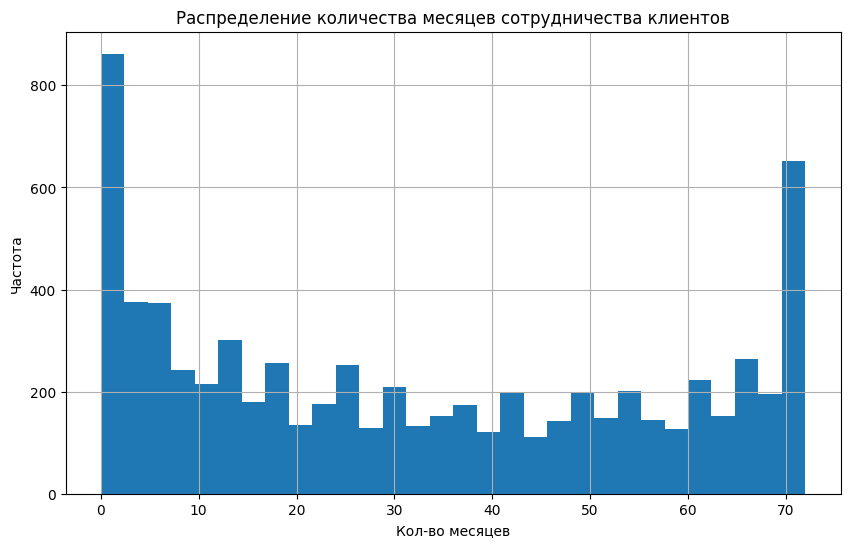

In [53]:
plt.figure(figsize=(10,6))
df_full['month_count'].hist(bins=30)
plt.title('Распределение количества месяцев сотрудничества клиентов')
plt.xlabel('Кол-во месяцев')
plt.ylabel('Частота')
plt.show()

На графике видны пики около 0 и на максимуме около 70. На промежутке от 10 до 65 примерно раномерно. Это говорит о том, что у компании есть группа постоянных клиентов (пик около 70 месяцев сотрудничества) и группа клиентов, недавно начавших пользоваться услугами компании (прервавших сотрудничество в ранний срок или продолжающих пользоваться услугами).  

Рассмотрим этот показатель с точки зрения ухода клиентов и общей выручки.

In [54]:
print('Доли ухода клиентов со сроком сотрудничества до 5 месяцев:', '\n',
      df_full.query('month_count <= 5').churn.value_counts(normalize=True), '\n'
      )
print('Доли ухода клиентов со сроком сотрудничества от 5 до 70 месяцев:', '\n',
      df_full.query('5 < month_count <= 70').churn.value_counts(normalize=True), '\n'
      )
print('Доли ухода клиентов со сроком сотрудничества свыше 70 месяцев:', '\n',
      df_full.query('month_count > 70').churn.value_counts(normalize=True), '\n'
      )

Доли ухода клиентов со сроком сотрудничества до 5 месяцев: 
 1   0.54
0   0.46
Name: churn, dtype: float64 

Доли ухода клиентов со сроком сотрудничества от 5 до 70 месяцев: 
 0   0.78
1   0.22
Name: churn, dtype: float64 

Доли ухода клиентов со сроком сотрудничества свыше 70 месяцев: 
 0   0.98
1   0.02
Name: churn, dtype: float64 



БОльший отток клиентов наблюдается в первые месяцы сотрудничества.

In [55]:
df_full['begin_month'] = df_full['begin_date'].dt.to_period('M')
df_full['end_month'] = df_full['end_date'].dt.to_period('M')

Рассмотрим более подробно ушедших клиентов. Отсортируем их по дате прихода. Выведем в отдельную таблицу по датам прихода число ушедших в определенный месяц клиентов.

In [56]:
churn_begin_end = df_full.query('end_date != @LOAD_DATE').pivot_table(index = 'begin_month', columns = 'end_month', values = 'customer_id', aggfunc = 'count')
display(churn_begin_end)

end_month,2019-10,2019-11,2019-12,2020-01
begin_month,,,,
2013-10,3.00,NaN,NaN,NaN
2013-11,2.00,NaN,NaN,NaN
2013-12,2.00,1.00,NaN,NaN
2014-01,2.00,1.00,1.00,3.00
2014-02,2.00,2.00,4.00,2.00
...,...,...,...,...
2019-08,29.00,21.00,18.00,8.00
2019-09,83.00,33.00,31.00,21.00
2019-10,NaN,93.00,29.00,22.00


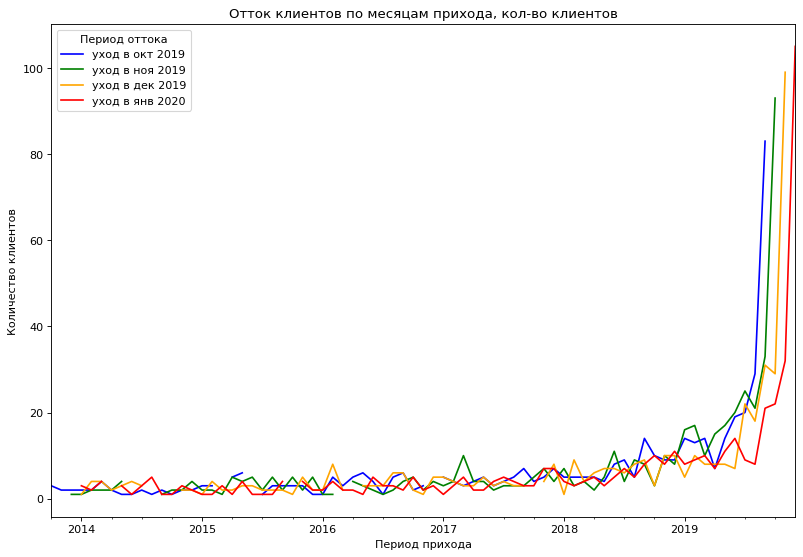

In [57]:
plt.figure(figsize=(12,8), dpi= 80)
churn_begin_end['2019-10'].plot(x='begin_month', color='blue')
churn_begin_end['2019-11'].plot(x='begin_month', color='green')
churn_begin_end['2019-12'].plot(x='begin_month', color='orange')
churn_begin_end['2020-01'].plot(x='begin_month', color='red')
plt.title('Отток клиентов по месяцам прихода, кол-во клиентов')
plt.xlabel('Период прихода')
plt.ylabel('Количество клиентов')
plt.legend([
    'уход в окт 2019',
    'уход в ноя 2019',
    'уход в дек 2019',
    'уход в янв 2020'], title='Период оттока', loc='upper left')

plt.show()

График показывает, что среди ушедших клиентов приходы более менее равномерны. Графики почти повторяют друг друга. Уход клиентов вырос в последние сроки. Вероятней всего это связано с тем, что начали заносить данные.

Посмотрим распределение признака количество месяцев контракта по ушедшим клиентам.

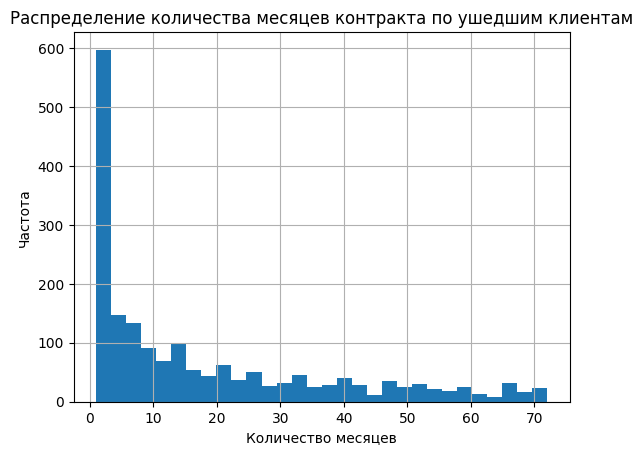

In [58]:
df_full.query('end_date != @LOAD_DATE').month_count.hist(bins=30)
plt.title('Распределение количества месяцев контракта по ушедшим клиентам')
plt.xlabel('Количество месяцев')
plt.ylabel('Частота')
plt.show()

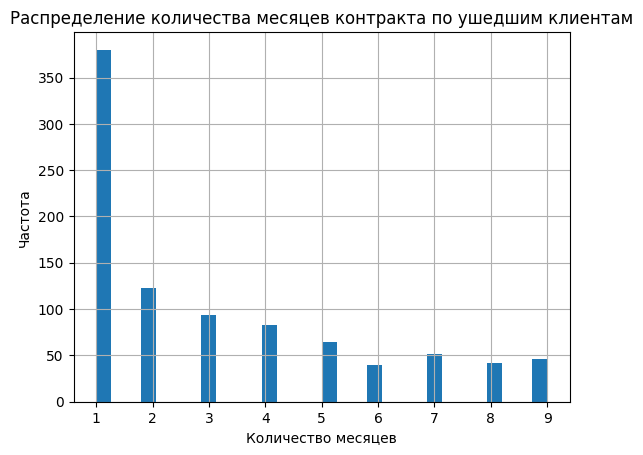

In [59]:
df_full.query('end_date != @LOAD_DATE and month_count < 10').month_count.hist(bins=30)
plt.title('Распределение количества месяцев контракта по ушедшим клиентам')
plt.xlabel('Количество месяцев')
plt.ylabel('Частота')
plt.show()

Среди ушедших клиентов очень многие ушли в первый месяц, чуть меньше - во второй и третий месяц сотрудничества и далее по убыванию.

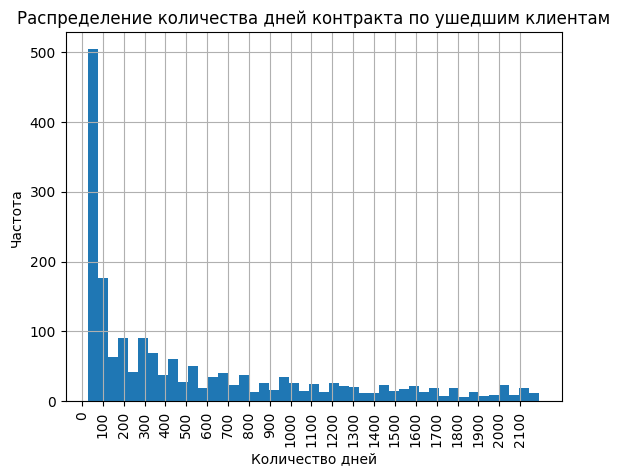

In [60]:
df_full.query('end_date != @LOAD_DATE').day_count.hist(bins=45, xrot=90)
plt.title('Распределение количества дней контракта по ушедшим клиентам')
plt.xlabel('Количество дней')
plt.xticks(np.arange(min(df_full['day_count']), max(df_full['day_count'])+1, 100.0))
plt.ylabel('Частота')
plt.show()

Посчитаем среднее значение вероятности оттока без влияния каких-либо параметров, а затем сравним с соответствующим показателем с учетом влияния категориальных признаков.

In [61]:
global_churn_rate = df_full.churn.mean()
print(f'Среднее значение вероятности ухода клиента (без влияния факторов): {global_churn_rate.round(3)}')

Среднее значение вероятности ухода клиента (без влияния факторов): 0.265


In [62]:
churn_influence = []
columns_list = df_full.select_dtypes('object').columns.tolist()
del columns_list[0]

for i in columns_list:
    print('Влияние признака', i, 'на целевой признак')
    churn_influence = df_full.groupby(i).churn.agg(['mean', 'count'])
    churn_influence['difference'] = churn_influence['mean'] - global_churn_rate
    churn_influence['risk'] = churn_influence['mean'] / global_churn_rate
    display(churn_influence)
    print('\n\n')

Влияние признака type на целевой признак


,mean,count,difference,risk
type,,,,
month-to-month,0.43,3875,0.16,1.61
one year,0.11,1473,-0.15,0.42
two year,0.03,1695,-0.24,0.11





Влияние признака paperless_billing на целевой признак


,mean,count,difference,risk
paperless_billing,,,,
no,0.16,2872,-0.10,0.62
yes,0.34,4171,0.07,1.26





Влияние признака payment_method на целевой признак


,mean,count,difference,risk
payment_method,,,,
bank transfer (automatic),0.17,1544,-0.10,0.63
credit card (automatic),0.15,1522,-0.11,0.57
electronic check,0.45,2365,0.19,1.71
mailed check,0.19,1612,-0.07,0.72





Влияние признака gender на целевой признак


,mean,count,difference,risk
gender,,,,
female,0.27,3488,0.00,1.01
male,0.26,3555,-0.00,0.99





Влияние признака senior_citizen на целевой признак


,mean,count,difference,risk
senior_citizen,,,,
no,0.24,5901,-0.03,0.89
yes,0.42,1142,0.15,1.57





Влияние признака partner на целевой признак


,mean,count,difference,risk
partner,,,,
no,0.33,3641,0.06,1.24
yes,0.20,3402,-0.07,0.74





Влияние признака dependents на целевой признак


,mean,count,difference,risk
dependents,,,,
no,0.31,4933,0.05,1.18
yes,0.15,2110,-0.11,0.58





Влияние признака internet_service на целевой признак


,mean,count,difference,risk
internet_service,,,,
dsl,0.19,2421,-0.08,0.71
fiber optic,0.42,3096,0.15,1.58
no,0.07,1526,-0.19,0.28





Влияние признака online_security на целевой признак


,mean,count,difference,risk
online_security,,,,
no,0.31,5024,0.05,1.18
yes,0.15,2019,-0.12,0.55





Влияние признака online_backup на целевой признак


,mean,count,difference,risk
online_backup,,,,
no,0.29,4614,0.03,1.10
yes,0.22,2429,-0.05,0.81





Влияние признака device_protection на целевой признак


,mean,count,difference,risk
device_protection,,,,
no,0.29,4621,0.02,1.08
yes,0.23,2422,-0.04,0.85





Влияние признака tech_support на целевой признак


,mean,count,difference,risk
tech_support,,,,
no,0.31,4999,0.05,1.18
yes,0.15,2044,-0.11,0.57





Влияние признака streaming_tv на целевой признак


,mean,count,difference,risk
streaming_tv,,,,
no,0.24,4336,-0.02,0.92
yes,0.30,2707,0.04,1.13





Влияние признака streaming_movies на целевой признак


,mean,count,difference,risk
streaming_movies,,,,
no,0.24,4311,-0.02,0.92
yes,0.30,2732,0.03,1.13





Влияние признака multiple_lines на целевой признак


,mean,count,difference,risk
multiple_lines,,,,
no,0.25,4072,-0.02,0.94
yes,0.29,2971,0.02,1.08





Влияние признака service на целевой признак


,mean,count,difference,risk
service,,,,
both,0.33,4835,0.06,1.24
internet,0.25,682,-0.02,0.94
phone,0.07,1526,-0.19,0.28


Из таблиц видим:

1. Значение признака type month-to-month повышает вероятность ухода клиента (0,16), one year - снижает (-0,15), two year - снижает в максимальной степени (-0,24).
2. Безналичный расчет (paperless_billing = 'yes') в незначительной степени повышает вероятность ухода (0,07), расчет наличными снижает (-0,1).
3. Способ оплаты electronic check повышает вероятность ухода (0,19). Способ оплаты bank transfer (automatic) и mailed check в равной степени снижают вероятность оттока (-0,1 и -0,07 соответственно), в еще большей степени снижает способ оплаты credit card (automatic) (-0,11).
4. Пол клиента практически не влияет на отток. Женщины более склонны к уходу (0,004), мужчины более стабильны (-0,004).
5. Наличие пенсионного статуса увеличивает вероятность ухода (0,15), отсутствие данного признака в незначительной степени снижает вероятность ухода (-0,03).
6. Наличие супруга(и) снижает вероятность оттока на 0,07, отсутствие - повышает на 0,06.
7. Наличие иждивенцев снижает вероятность оттока на 0,11, отсутствие - повышает на 0,05.
8. Отсутствие интернет-услуг у пользователя снижает вероятность оттока на 0,19 по всем признакам.
9. Тип подключения dsl снижает вероятность оттока на 0,08, fiber optic - повышает на 0,15.
10. Наличие блокировки небезопасных сайтов снижает вероятность оттока на 0,12, отсутствие - повышает на 0,05.
11. Наличие облачного хранилища для резервного копирования данных снижает вероятность оттока на 0,05, отсутствие - повышает на 0,03.  
12. Наличие антивируса снижает вероятность оттока на 0,04, отсутствие - повышает на 0,03.
13. Наличие выделенной линии технической поддержки снижает вероятность оттока на 0,11, отсутствие - повышает на 0,05.
14. Наличие и отсутствие стримингового телевидения и каталога фильмов в равной мере повышают вероятность оттока, снижает отток только отсутствие данного признака (клиент не пользуется услугами).
15. Наличие возможности подключения телефонного аппарата к нескольким линиям одновременно повышает вероятность оттока клиента, отсутствие данной возможности снижает вероятность оттока.

Нижеследующие графики отлично отражают влияние признаков на целевую переменную.

In [63]:
df_full_col = df_full.columns.tolist()
del df_full_col[0:3]
del df_full_col[4]
del df_full_col[-2:]

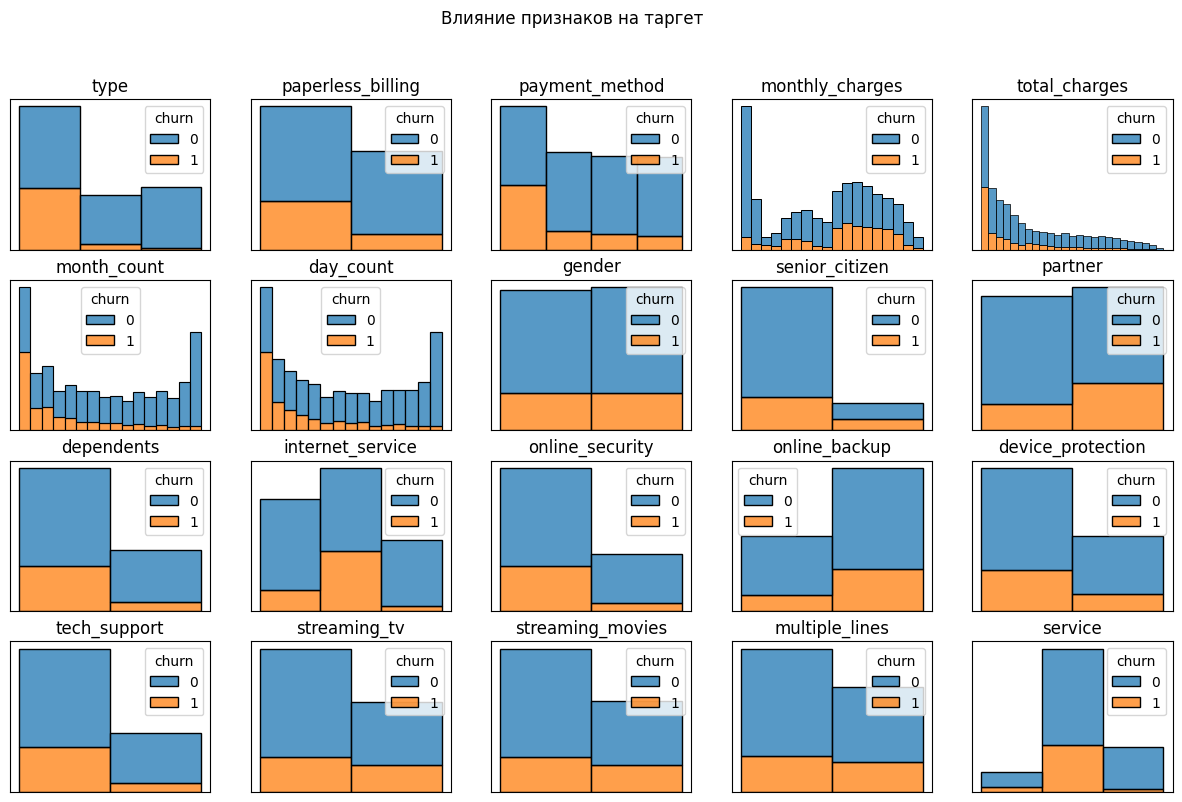

In [64]:
fig, axs = plt.subplots(4, 5, figsize=(15, 9))
fig.suptitle('Влияние признаков на таргет')
for i in range(4):
    for j in range(5):
        axs[i, j] = sns.histplot(df_full, x = df_full_col[i*5+j], hue = 'churn', multiple = 'stack', ax=axs[i, j])
        axs[i, j].set_title(df_full_col[i*5+j])
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)

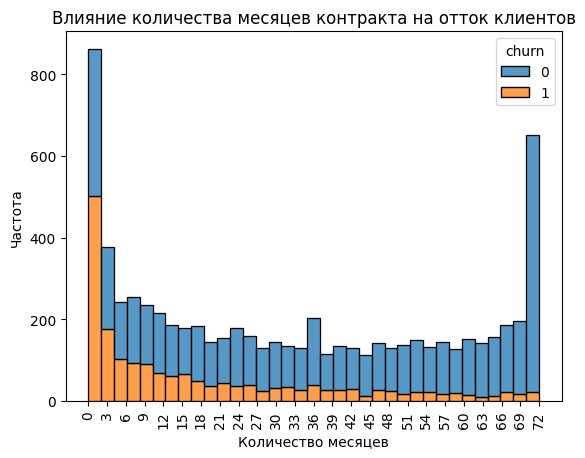

In [71]:
sns.histplot(df_full, x = df_full['month_count'], hue = 'churn', multiple = 'stack', bins=35)
plt.title('Влияние количества месяцев контракта на отток клиентов')
plt.xlabel('Количество месяцев')
plt.xticks(np.arange(min(df_full['month_count']), max(df_full['month_count'])+1, 3.0), rotation=90)
plt.ylabel('Частота')
plt.show()

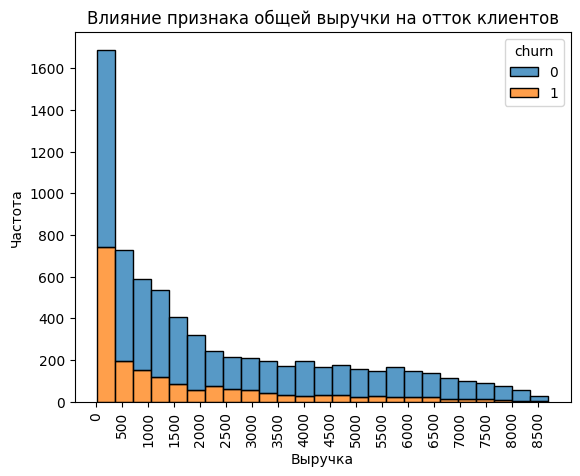

In [76]:
sns.histplot(df_full, x = df_full['total_charges'], hue = 'churn', multiple = 'stack')
plt.title('Влияние признака общей выручки на отток клиентов')
plt.xlabel('Выручка')
plt.xticks(np.arange(0, max(df_full['total_charges'])+1, 500.0), rotation=90)
plt.ylabel('Частота')
plt.show()

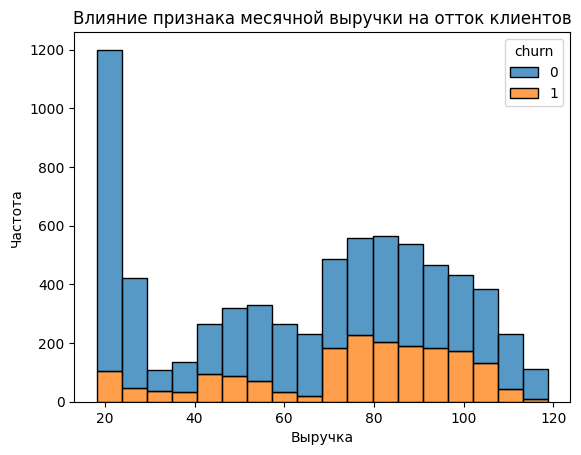

In [77]:
sns.histplot(df_full, x = df_full['monthly_charges'], hue = 'churn', multiple = 'stack')
plt.title('Влияние признака месячной выручки на отток клиентов')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()

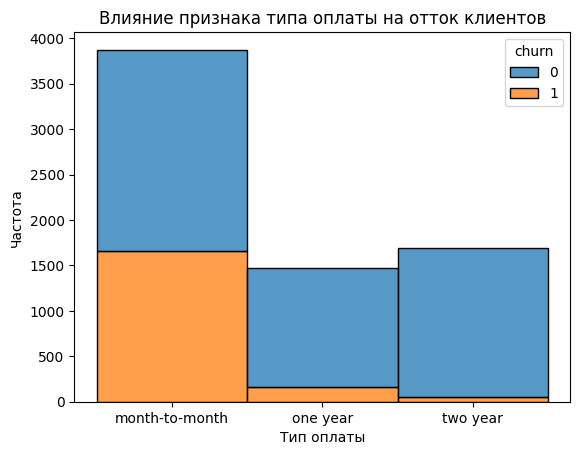

In [78]:
sns.histplot(df_full, x = df_full['type'], hue = 'churn', multiple = 'stack')
plt.title('Влияние признака типа оплаты на отток клиентов')
plt.xlabel('Тип оплаты')
plt.ylabel('Частота')
plt.show()

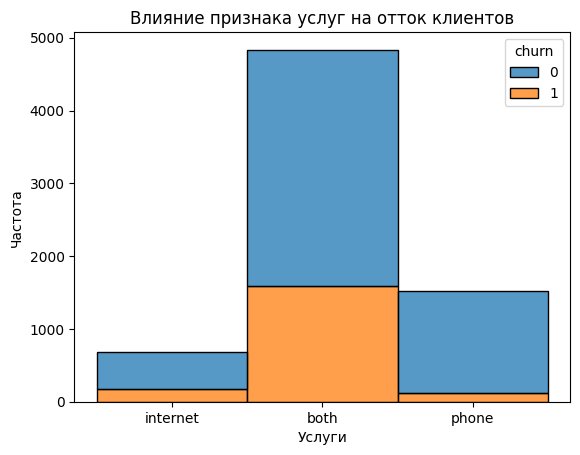

In [79]:
sns.histplot(df_full, x = df_full['service'], hue = 'churn', multiple = 'stack')
plt.title('Влияние признака услуг на отток клиентов')
plt.xlabel('Услуги')
plt.ylabel('Частота')
plt.show()

### Выводы по шагу 1

Больше всего склонны к уходу клиенты в первые два месяца контракта с ежемесячным типом оплаты. С общей выручкой до 350 и оплатой 70-100 за месяц. Клиенты, использующие услугу только телефон или только интернет, меньше всего склонны к оттоку, использующие оба вида услуг, - больше всего склонны к уходу.

## Построение, обучение и тестирование модели

### Предобработка и анализ данных для целей машинного обучения

In [80]:
df = df_full
df.head().T

,0,1,2,3,4
customer_id,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
begin_date,2020-01-01 00:00:00,2017-04-01 00:00:00,2019-10-01 00:00:00,2016-05-01 00:00:00,2019-09-01 00:00:00
end_date,2020-02-01 00:00:00,2020-02-01 00:00:00,2019-12-01 00:00:00,2020-02-01 00:00:00,2019-11-01 00:00:00
type,month-to-month,one year,month-to-month,one year,month-to-month
paperless_billing,yes,no,yes,no,yes
payment_method,electronic check,mailed check,mailed check,bank transfer (automatic),electronic check
monthly_charges,29.85,56.95,53.85,42.30,70.70
churn,0,0,1,0,1
total_charges,29.85,"1,889.50",108.15,"1,840.75",151.65
month_count,1,34,2,45,2


In [81]:
df1 = df

In [82]:
df1 = df1.drop(['customer_id', 'begin_month', 'end_month', 'month_count'], axis=1)

Проверим, появились ли полные дубликаты после удаления признака customer_id.

In [83]:
print('Количество полных дубликатов в таблице после удаления customer_id:', df1.duplicated().sum())

Количество полных дубликатов в таблице после удаления customer_id: 13


In [84]:
duplicate_rows = df1[df1.duplicated()]
duplicate_rows.T

,1491,1932,2713,2892,3301,3754,5506,5736,6499,6609,6706,6774,6924
begin_date,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2019-10-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2019-10-01 00:00:00
end_date,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2019-11-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2019-11-01 00:00:00
type,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month,month-to-month
paperless_billing,no,no,yes,no,yes,no,no,no,no,yes,no,no,yes
payment_method,mailed check,mailed check,mailed check,mailed check,electronic check,mailed check,mailed check,mailed check,mailed check,mailed check,mailed check,mailed check,electronic check
monthly_charges,19.55,20.20,20.45,20.45,69.60,20.05,20.20,20.05,20.30,20.10,19.90,19.65,69.35
churn,0,0,0,0,1,0,0,0,0,1,0,0,1
total_charges,19.55,20.20,20.45,20.45,69.60,20.05,20.20,20.05,20.30,20.10,19.90,19.65,69.35
day_count,31,31,31,31,31,31,31,31,31,31,31,31,31
gender,female,male,male,male,female,male,male,male,male,male,female,female,male


In [85]:
df1.shape

(7043, 22)

Удалим дубликаты.

In [86]:
df1 = df1.drop_duplicates().reset_index(drop=True)
df1.shape

(7030, 22)

Удалим признаки дата начала контракта и дата завершения контракта, тк они участвуют в формировании признака day_count и могут давать утечку данных.

In [87]:
df1 = df1.drop(['begin_date', 'end_date'], axis=1)

Рассмотрим, насколько существенный вклад вносит каждый из признаков в вероятность churn=1.

In [88]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df1.churn)

In [89]:
# categorical_features + discret_num_features - target_feature
a = df1.columns.tolist()
del a[4]
mi_features = a
mi = df1[mi_features].apply(mutual_info_churn_score)
mi_Series = pd.Series(mi.sort_values(ascending=False))

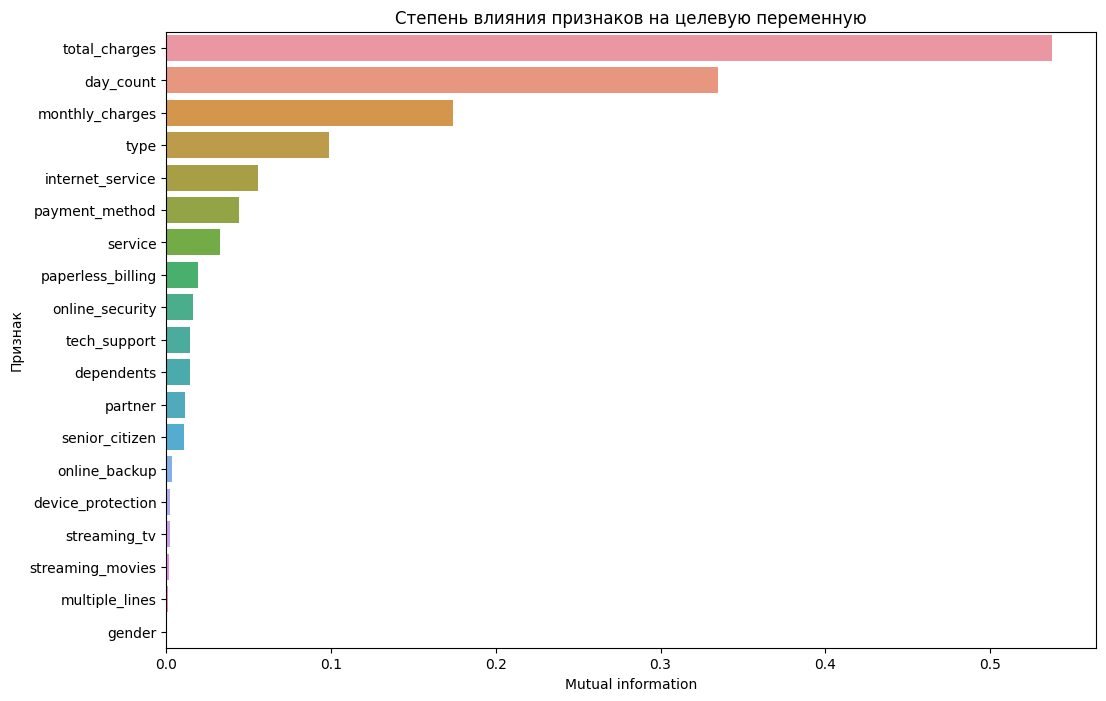

In [90]:
plt.figure(figsize=(12,8))
sns.barplot(x=mi_Series, y=mi_Series.index)
plt.xlabel('Mutual information')
plt.ylabel('Признак')
plt.title('Степень влияния признаков на целевую переменную')
plt.show()

По графику видно: наибольшее влияние на таргет оказывают total_charges, затем идет day_count, monthly_charges, менее значимы показатели type, internet_service и payment_method, еще меньше - service, paperless_billing и прочие. Остальные влияния практически не оказывают. Признак gender можно удалить.

In [91]:
df1 = df1.drop('gender', axis=1)

Выделим признаки в переменную X, а показатель оттока в целевую переменную y.

In [92]:
X = df1.drop('churn', axis=1)
y = df1['churn']
print(X.shape)
print(y.shape)

(7030, 18)
(7030,)


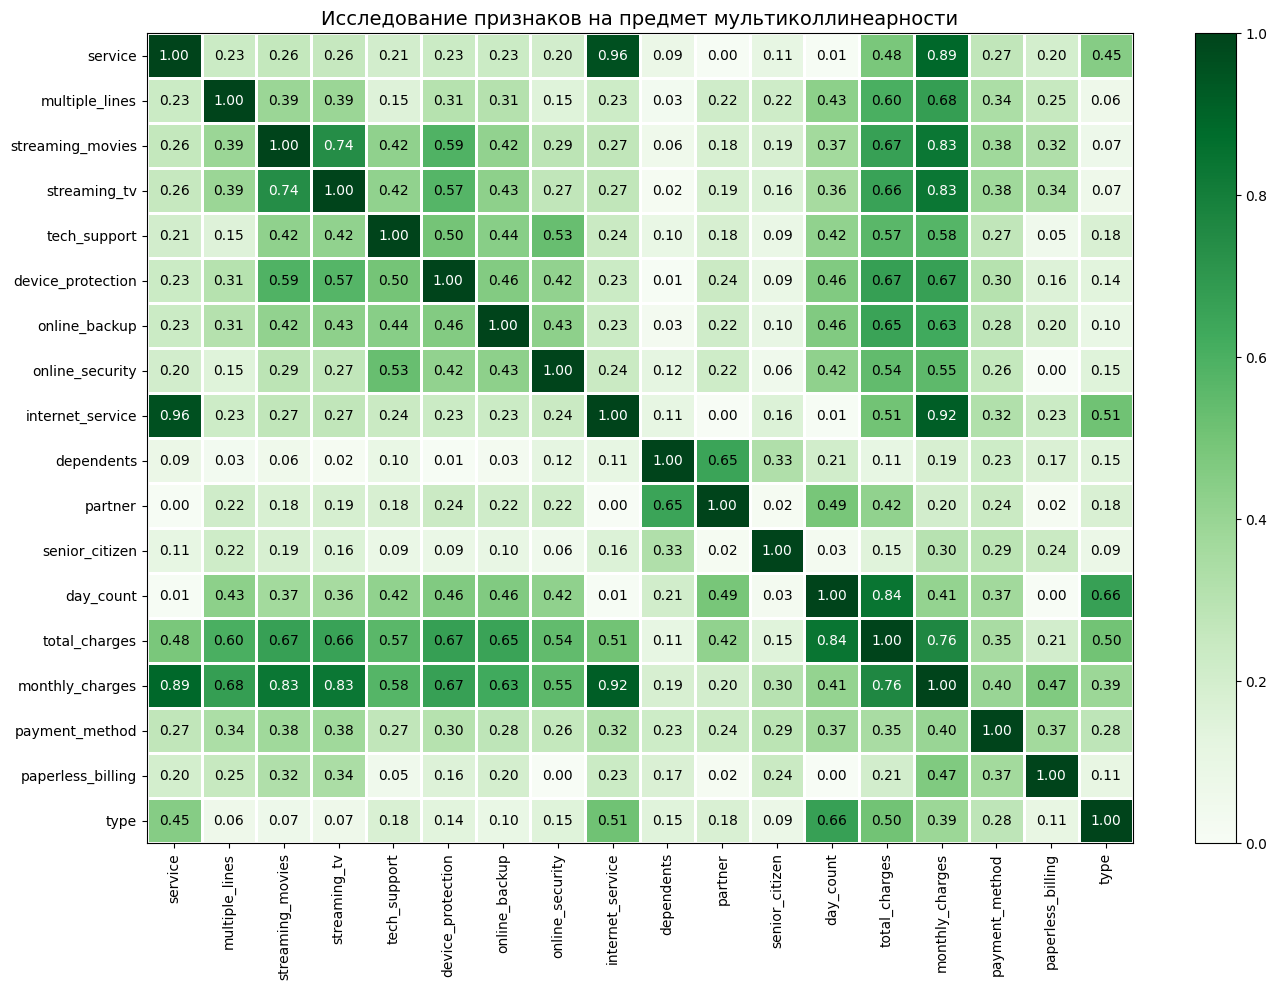

In [93]:
interval_cols = X.select_dtypes('number').columns.tolist()
phik_overview = X.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title="Исследование признаков на предмет мультиколлинеарности",
                        fontsize_factor=1,
                        figsize=(14, 10))
plt.tight_layout()

Наблюдаем значительную корреляцию между признаками услуг интернета 95-97%.
Признак monthly_charges тоже сильно коррелирует с другими признаками. Month_count и total_charges тоже имеют между собой сильную корреляцию. Корреляция категориальных признаков может быть нелинейная, поэтому предлагаю оставить данные признаки.

Разобьем имеющуюся выборку на обучающую и тестовую. Кроссвалидацию будем применять в рамках построения пайплайна.

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y)
print('Размер признаков на обучающей выборке: ', X_train.shape)
print('Размер таргета на обучающей выборке: ',  y_train.shape)
print('Размер признаков на тестовой выборке: ', X_test.shape)
print('Размер таргета на тестовой выборке: ', y_test.shape)

Размер признаков на обучающей выборке:  (5272, 18)
Размер таргета на обучающей выборке:  (5272,)
Размер признаков на тестовой выборке:  (1758, 18)
Размер таргета на тестовой выборке:  (1758,)


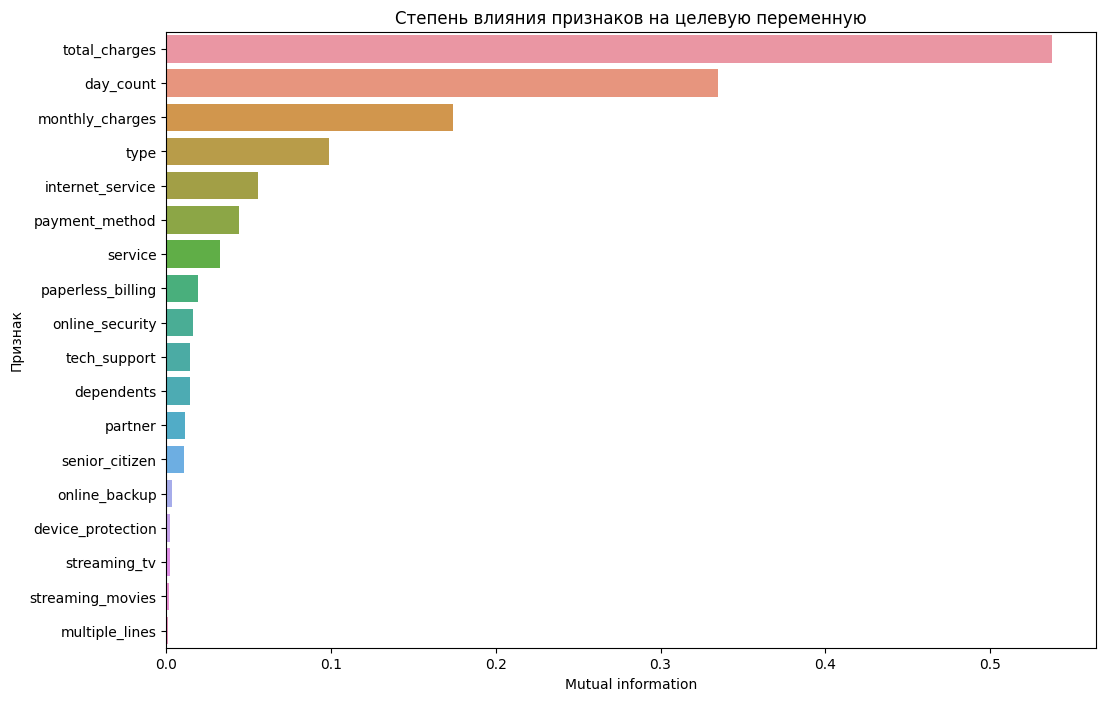

In [95]:
mi_features = X_train.columns.tolist()
mi = df1[mi_features].apply(mutual_info_churn_score)
mi_Series = pd.Series(mi.sort_values(ascending=False))

plt.figure(figsize=(12,8))
sns.barplot(x=mi_Series, y=mi_Series.index)
plt.xlabel('Mutual information')
plt.ylabel('Признак')
plt.title('Степень влияния признаков на целевую переменную')
plt.show()

In [96]:
X_train.dtypes

type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
day_count              int64
senior_citizen        object
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
multiple_lines        object
service               object
dtype: object

Посчитаем веса классов целевой переменной для передачи модели обучения.

In [97]:
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {k: v for k, v in zip(classes, weights)}
print('Class weights:', class_weights)

Class weights: {0: 0.6806093467596178, 1: 1.8842030021443887}


### Построение и анализ моделей

#### Pipeline + RandomizedSearchCV LogisticRegression

In [98]:
X_train_lgr = X_train.copy()
y_train_lgr = y_train.copy()

In [99]:
X_train_lgr.dtypes

type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
day_count              int64
senior_citizen        object
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
multiple_lines        object
service               object
dtype: object

In [100]:
cat_columns_lgr = X_train_lgr.select_dtypes('object').columns.tolist()
num_columns_lgr = X_train_lgr.select_dtypes('number').columns.tolist()

In [101]:
num_pipline = Pipeline([('scaler', StandardScaler())#,
                       # ('drop_correlations', DropCorrelatedFeatures())
                       ])

columns_pipeline=ColumnTransformer([('num_cols', num_pipline, num_columns_lgr),
                                    ('category_encoder',
                                        OneHotEncoder(drop='first'), cat_columns_lgr)],
                                        remainder='passthrough')
columns_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_cols',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['monthly_charges', 'total_charges',
                                  'day_count']),
                                ('category_encoder',
                                 OneHotEncoder(drop='first'),
                                 ['type', 'paperless_billing', 'payment_method',
                                  'senior_citizen', 'partner', 'dependents',
                                  'internet_service', 'online_security',
                                  'online_backup', 'device_protection',
                                  'tech_support', 'streaming_tv',
                                  'streaming_movies', 'multiple_lines',
                                  'service'])])

In [102]:
pipeline = make_pipeline(columns_pipeline) #, DropDuplicateFeatures() , SMOTE()

In [103]:
# def outlier_detector(X, y):
#     outlier_index =  LocalOutlierFactor().fit_predict(X)
#     return X[outlier_index == 1], y[outlier_index == 1]

In [104]:
# pipeline.steps.append(('outlier_detector', FunctionSampler(func=outlier_detector)))

In [105]:
pipeline.steps.append(('clf_lgr', LogisticRegression(random_state=RANDOM_STATE)))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'day_count']),
                                                 ('category_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines',
                                                   'service'])])),
                ('clf_lgr', LogisticRegression(random_state=12345))])

In [106]:
params={
    'clf_lgr__solver': ['saga', 'liblinear'],
    'clf_lgr__penalty': ['l2', 'l1'],
    'clf_lgr__C': [1, 5, 10],
    'clf_lgr__class_weight':['balanced', None, class_weights]
}

In [107]:
%%time
grid_lgr = RandomizedSearchCV(
    pipeline,
    cv=5,
    random_state=RANDOM_STATE,
    n_iter=100,
    n_jobs=-1,
    param_distributions=params,
    scoring = 'roc_auc'
    )

grid_lgr.fit(X_train_lgr, y_train_lgr)
print(grid_lgr.best_score_)
print(grid_lgr.best_estimator_)

0.8500807566522968
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'day_count']),
                                                 ('category_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
         

#### Pipeline + RandomizedSearchCV RandomForestClassifier

In [108]:
X_train_rf = X_train.copy()
y_train_rf = y_train.copy()

print(X_train_rf.dtypes)

cat_columns_rf = X_train_lgr.select_dtypes('object').columns.tolist()
num_columns_rf = X_train_lgr.select_dtypes('number').columns.tolist()

type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
day_count              int64
senior_citizen        object
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
multiple_lines        object
service               object
dtype: object


In [109]:
num_pipline = Pipeline([('scaler', StandardScaler())
                       ])

columns_pipeline=ColumnTransformer([('num_cols', num_pipline, num_columns_lgr),
                                    ('category_encoder',
                                        OneHotEncoder(drop='first'), cat_columns_lgr)],
                                        remainder='passthrough')

pipeline = make_pipeline(columns_pipeline, SMOTE())
pipeline.steps.append(('clf_rf', RandomForestClassifier(random_state=RANDOM_STATE)))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'day_count']),
                                                 ('category_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines',
                                                   'service'])])),
                ('smote', SMOTE()),
                ('clf_rf', RandomForestClassifier(random_state=12345))])

In [110]:
params={
    'clf_rf__n_estimators' : [20, 50, 100, 150],
    'clf_rf__criterion' : ['gini', 'entropy'],
    'clf_rf__max_depth' : [5, 10, 20]
    ,
    'clf_rf__class_weight':['balanced', class_weights]
}

In [111]:
%%time
grid_rf = RandomizedSearchCV(
    pipeline,
    cv=5,
    n_iter=1000,
    n_jobs=-1,
    param_distributions=params,
    scoring = 'roc_auc'
    )

grid_rf.fit(X_train_rf, y_train_rf)
print(grid_rf.best_score_)
print(grid_rf.best_estimator_)

0.8596044284688684
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'day_count']),
                                                 ('category_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
         

#### Pipeline + RandomizedSearchCV LightGBM

In [112]:
X_train_lgbm = X_train.copy()
y_train_lgbm = y_train.copy()

print(X_train_lgbm.dtypes)

cat_columns_lgbm = X_train_lgbm.select_dtypes('object').columns.tolist()
num_columns_lgbm = X_train_lgbm.select_dtypes('number').columns.tolist()

type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
day_count              int64
senior_citizen        object
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
multiple_lines        object
service               object
dtype: object


In [113]:
num_pipline = Pipeline([('scaler', StandardScaler())
                       ])

columns_pipeline=ColumnTransformer([('num_cols', num_pipline, num_columns_lgbm),
                                    ('category_encoder',
                                        OneHotEncoder(drop='first'), cat_columns_lgbm)],
                                        remainder='passthrough')

pipeline = make_pipeline(columns_pipeline)
pipeline.steps.append(('clf_lgbm', LGBMClassifier(random_state=RANDOM_STATE)))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'day_count']),
                                                 ('category_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines',
                                                   'service'])])),
                ('clf_lgbm', LGBMClassifier(random_state=12345))])

In [114]:
params={'clf_lgbm__learning_rate': [0.01, 0.1, 0.3, 0.5],
        'clf_lgbm__class_weight':['balanced', None, class_weights]}

In [115]:
%%time
grid_lgbm = RandomizedSearchCV(
    pipeline,
    random_state=RANDOM_STATE,
    cv=5,
    n_iter=100,
    n_jobs=-1,
    param_distributions=params,
    scoring = 'roc_auc'
    )

grid_lgbm.fit(X_train_lgbm, y_train_lgbm)
print(grid_lgbm.best_score_)
print(grid_lgbm.best_estimator_)

[LightGBM] [Info] Number of positive: 1399, number of negative: 3873
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 5272, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.8894543250636009
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                             

#### Pipeline + RandomizedSearchCV CatBoostClassifier

In [116]:
X_train_cat = X_train.copy()
y_train_cat = y_train.copy()

cat_columns_cat = X_train_cat.select_dtypes('object').columns.tolist()
num_columns_cat = X_train_cat.select_dtypes('number').columns.tolist()

In [121]:
num_pipline = Pipeline([('scaler', StandardScaler())
                       ])

columns_pipeline=ColumnTransformer([('category_encoder',
                                        OrdinalEncoder(), cat_columns_cat)],
                                        remainder='passthrough')

pipeline = make_pipeline(columns_pipeline)
pipeline.steps.append(('clf_cat', CatBoostClassifier(random_state=RANDOM_STATE)))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_encoder',
                                                  OrdinalEncoder(),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines',
                                                   'service'])])),
                ('clf_cat',
                 <catboost.core.CatBoostClassifier object at 0x7ad61ec4aec0>)])

In [122]:
params={
    'clf_cat__learning_rate': [0.01, 0.05, 0.1, 0.5, 0.7],
    #'clf_cat__iteratons': [700],
    'clf_cat__class_weights': [None, class_weights],
       }

In [123]:
%%time
grid_cat = RandomizedSearchCV(
    pipeline,
    random_state=RANDOM_STATE,
    cv=5,
    n_iter=100,
    n_jobs=-1,
    param_distributions=params,
    scoring = 'roc_auc'
    )

grid_cat.fit(X_train_cat, y_train_cat)
print(grid_cat.best_score_)
print(grid_cat.best_estimator_)

0:	learn: 0.6434217	total: 50.1ms	remaining: 50.1s
1:	learn: 0.6026830	total: 54.5ms	remaining: 27.2s
2:	learn: 0.5736764	total: 60ms	remaining: 19.9s
3:	learn: 0.5529337	total: 63.2ms	remaining: 15.7s
4:	learn: 0.5348492	total: 66.6ms	remaining: 13.3s
5:	learn: 0.5219243	total: 69.3ms	remaining: 11.5s
6:	learn: 0.5083852	total: 72.4ms	remaining: 10.3s
7:	learn: 0.4999460	total: 75.4ms	remaining: 9.35s
8:	learn: 0.4925771	total: 78.4ms	remaining: 8.64s
9:	learn: 0.4855599	total: 82ms	remaining: 8.12s
10:	learn: 0.4781408	total: 85ms	remaining: 7.64s
11:	learn: 0.4718164	total: 88ms	remaining: 7.25s
12:	learn: 0.4677669	total: 91.1ms	remaining: 6.92s
13:	learn: 0.4639954	total: 94.3ms	remaining: 6.64s
14:	learn: 0.4596998	total: 97.6ms	remaining: 6.41s
15:	learn: 0.4554145	total: 101ms	remaining: 6.2s
16:	learn: 0.4517245	total: 104ms	remaining: 6.02s
17:	learn: 0.4487319	total: 107ms	remaining: 5.86s
18:	learn: 0.4464416	total: 111ms	remaining: 5.71s
19:	learn: 0.4434087	total: 114ms	r

#### Анализ моделей


In [124]:
data = pd.DataFrame({'Method': ['Pipeline+RSCV+LogReg', 'Pipeline+RSCV+RandForest', 'Pipeline+RSCV+LightGBM', 'Pipeline+RSCV+CatBoost'],
                   'Roc_auc': [grid_lgr.best_score_, round(grid_rf.best_score_, 4), round(grid_lgbm.best_score_, 4), round(grid_cat.best_score_, 4)],
                    'Время обучения, сек': ['-','-','-','-']})
data

,Method,Roc_auc,"Время обучения, сек"
0,Pipeline+RSCV+LogReg,0.85,-
1,Pipeline+RSCV+RandForest,0.86,-
2,Pipeline+RSCV+LightGBM,0.89,-
3,Pipeline+RSCV+CatBoost,0.90,-


По величине метрики лучшая модель CatBoost.

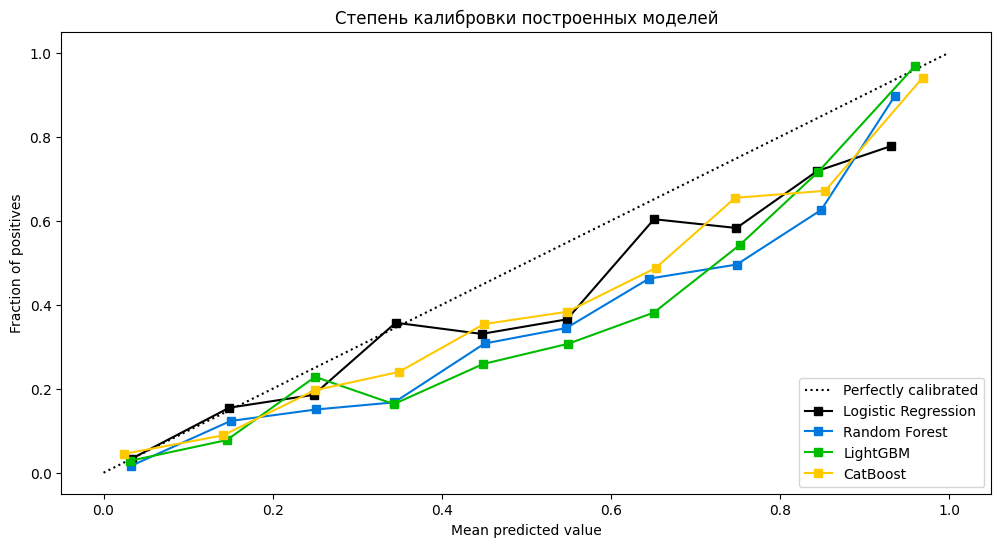

In [125]:
lgr_probas = grid_lgr.predict_proba(X_test)
rf_probas = grid_rf.predict_proba(X_test)
lgbm_probas = grid_lgbm.predict_proba(X_test)
cat_probas = grid_cat.predict_proba(X_test)
probas_list = [lgr_probas, rf_probas, lgbm_probas, cat_probas]
clf_names = ['Logistic Regression', 'Random Forest', 'LightGBM', 'CatBoost']
skplt.metrics.plot_calibration_curve(y_test, probas_list, clf_names, figsize=(12,6))
plt.title('Степень калибровки построенных моделей')
plt.show()

По степени калибровки лучшей является модель Logistic Regression, затем идет CatBoost и Random Forest. Учитывая величину метрики, можно утверждать, что CatBoost является лучшей моделью.

In [126]:
print('Лучшая модель:', grid_cat.best_estimator_)
print('Параметры лучшей модели: ', grid_cat.best_params_)

Лучшая модель: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_encoder',
                                                  OrdinalEncoder(),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                        

Лучшей моделью оказалась бустинговая модель CatBoostClassifier с шагом обучения 0,1 и веcами для классов {0: 0.68, 1: 1.88}, встроенная в pipeline с кодированием категориальных переменных методом OrdinalEncoder. Метрика ROC_AUC составила 90%.

#### Влияние признаков на результат предсказания лучшей модели

Посмотрим степень важности различных признаков на прогноз лучшей модели.

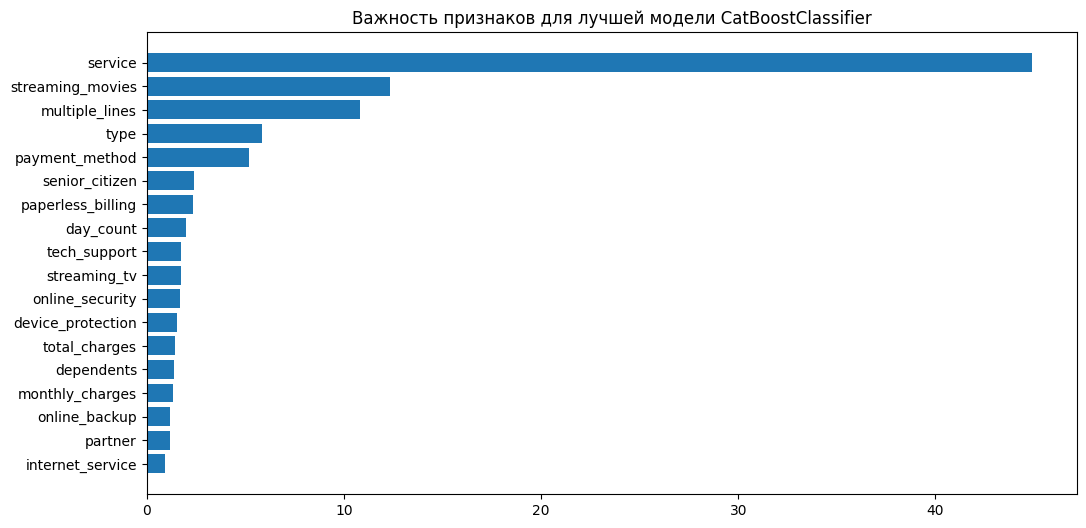

In [127]:
feature_importance = grid_cat.best_estimator_.steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Важность признаков для лучшей модели CatBoostClassifier')
plt.show()

Наиболее важный признак для прогнозирования модели оказался service, затем в равной степени streaming_movies и multiple_lines, в еще меньшей - type и payment_method и далее все остальные.

### Тестирование лучшей модели

Прогоним лучшую модель на тестовых данных.

In [128]:
print('ROC-AUC на тестовой выборке:', round(roc_auc_score(y_test, grid_cat.predict_proba(X_test)[:,1]), 3))

ROC-AUC на тестовой выборке: 0.912


### Выводы по шагу 2

Лучшей моделью оказалась бустинговая модель CatBoostClassifier с шагом обучения 0,1 и веcами для классов {0: 0.68, 1: 1.88}, встроенная в pipeline с кодированием категориальных переменных методом OrdinalEncoder. Метрика ROC_AUC составила на обучающей выборке и на тестовых данных 90.4% и 91.2% соответственно. Модель достаточно хорошо откалибрована, поэтому должна быть достаточно стабильной на других тестовых данных.


## Выводы и результаты исследовательского проекта. Рекомендации

### Бизнес-анализ

In [129]:
probabilities_test = grid_cat.best_estimator_.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

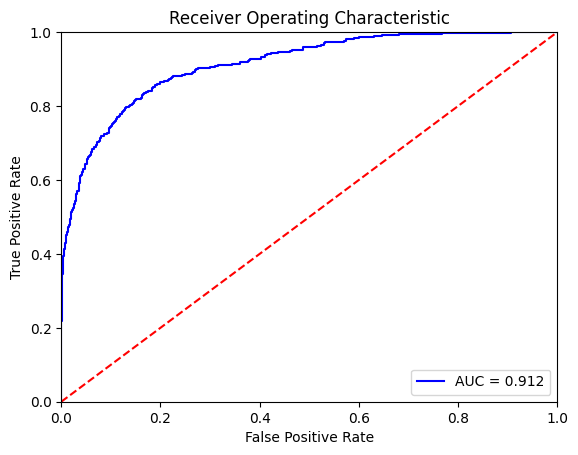

In [130]:
fpr, tpr, threshold = metrics.roc_curve(y_test, probabilities_one_test)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [131]:
for threshhold in np.arange(0.28, 0.68, 0.02):
    predicted_test = probabilities_one_test > threshhold
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    f1 = f1_score(y_test, predicted_test)
    roc_auc = roc_auc_score(y_test, predicted_test)
    print('Порог: {:.2f} | Точность: {:.3f}, Полнота: {:.3f}, F1: {:.3f}, ROC-Auc: {:.3f}'.format(threshhold, precision, recall, f1, roc_auc))

Порог: 0.28 | Точность: 0.620, Полнота: 0.857, F1: 0.719, ROC-Auc: 0.833
Порог: 0.30 | Точность: 0.628, Полнота: 0.839, F1: 0.719, ROC-Auc: 0.830
Порог: 0.32 | Точность: 0.640, Полнота: 0.835, F1: 0.725, ROC-Auc: 0.833
Порог: 0.34 | Точность: 0.648, Полнота: 0.820, F1: 0.724, ROC-Auc: 0.830
Порог: 0.36 | Точность: 0.661, Полнота: 0.818, F1: 0.731, ROC-Auc: 0.833
Порог: 0.38 | Точность: 0.669, Полнота: 0.805, F1: 0.731, ROC-Auc: 0.831
Порог: 0.40 | Точность: 0.681, Полнота: 0.801, F1: 0.736, ROC-Auc: 0.833
Порог: 0.42 | Точность: 0.687, Полнота: 0.794, F1: 0.737, ROC-Auc: 0.832
Порог: 0.44 | Точность: 0.699, Полнота: 0.779, F1: 0.737, ROC-Auc: 0.829
Порог: 0.46 | Точность: 0.709, Полнота: 0.771, F1: 0.738, ROC-Auc: 0.828
Порог: 0.48 | Точность: 0.716, Полнота: 0.760, F1: 0.737, ROC-Auc: 0.825
Порог: 0.50 | Точность: 0.725, Полнота: 0.752, F1: 0.738, ROC-Auc: 0.824
Порог: 0.52 | Точность: 0.736, Полнота: 0.739, F1: 0.737, ROC-Auc: 0.821
Порог: 0.54 | Точность: 0.738, Полнота: 0.728, F1: 

С помощью анализа разных порогов классификации можно оптимизировать F-меру при заданном ROC-AUC.

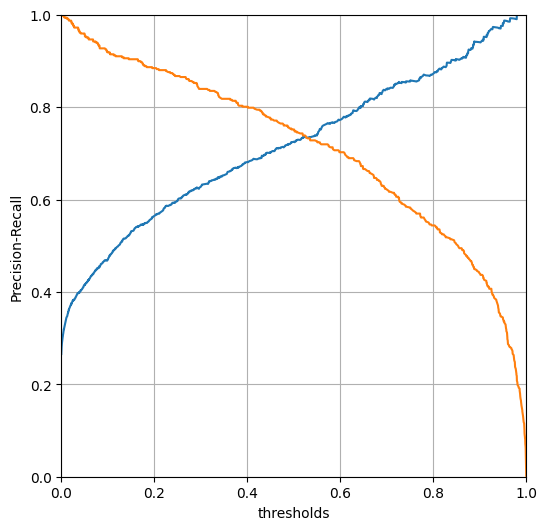

Best threshold = 0.526


In [132]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_test[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(thresholds, precision[:-1])
plt.xlabel('thresholds')
plt.ylabel('Precision-Recall')
plt.plot(thresholds, recall[:-1])
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(f'Best threshold = {np.round(thresholds[np.argmin(np.abs(precision - recall))], 3)}')

При пороге 0,568 наблюдаем оптимальное соотношение параметров: высокая метрика precision (0.74) при сохранении на должном уровне recall (0.749) и остальных метрик: на лчень хорошем уровне F1 = 74.5%, ROC-Auc = 82.7%. На этом пороге модель максимизирует долю истинных положительных и долю истинных отрицательных результатов, минимизируя вероятность ложной тревоги - ошибки первого рода. На этом пороге показатели точности и полноты 0.610 и 0.627 соответственно. На дальнейших порогах точность продолжает расти, остальные метрики начинают постепенно падать.

С другой стороны в данной задаче определения вероятности ухода клиента более важно максимизировать метрику precision и ложно отправить скидку или письмо клиенту, который на самом деле не хотел уходить из компании, чтобы оставить его. Чем не предоставить скидку и потерять клиента. Здесь нужно смотреть выручку, которую приносит клиент (определить категорию клиента по типу тарифа), возможный размер предоставляемой скидки и пр. Эти вопросы нужно рассматривать исходя из требований заказчика.  

Посмотрим вероятность ухода каждого клиента во втором столбце по всем строкам features_valid. Это второй столбец.

In [133]:
probabilities_test

array([[0.9009976 , 0.0990024 ],
       [0.99167744, 0.00832256],
       [0.40212641, 0.59787359],
       ...,
       [0.92388761, 0.07611239],
       [0.99898289, 0.00101711],
       [0.86106605, 0.13893395]])

Сколько всего клиентов отнесены к 1 классу при пороге выше 0,5.

In [134]:
exited_desicion = (probabilities_one_test >= 0.568)
exited_desicion

array([False, False,  True, ..., False, False, False])

In [135]:
exited_desicion.sum()

440

Следующий список клиентов рекомендуется включить в программу лояльности при пороге 0,568 и выше.

In [140]:
X_test[exited_desicion]

,type,paperless_billing,payment_method,monthly_charges,total_charges,day_count,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,service
880,month-to-month,yes,electronic check,110.10,"1,043.30",306,no,no,no,fiber optic,yes,yes,yes,yes,yes,yes,no,both
2502,month-to-month,yes,electronic check,75.70,189.20,61,no,no,no,fiber optic,yes,no,no,no,no,no,no,both
6118,month-to-month,yes,credit card (automatic),95.90,"1,777.90",579,yes,no,no,fiber optic,no,no,yes,no,yes,yes,no,both
2526,month-to-month,yes,bank transfer (automatic),80.10,679.30,245,no,no,no,fiber optic,no,no,no,no,yes,no,no,both
3691,month-to-month,yes,electronic check,49.15,270.80,183,no,yes,no,dsl,no,no,no,yes,no,no,no,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,month-to-month,yes,electronic check,100.25,"1,064.65",303,no,yes,yes,fiber optic,yes,no,no,no,yes,yes,yes,both
2426,month-to-month,yes,bank transfer (automatic),99.25,"3,777.15",1156,no,no,yes,fiber optic,no,no,yes,no,yes,yes,yes,both
3027,month-to-month,yes,electronic check,71.05,"3,444.85",1522,yes,yes,no,fiber optic,no,no,no,no,no,no,no,both
1456,month-to-month,yes,electronic check,100.00,"1,534.75",487,no,yes,no,fiber optic,no,yes,no,no,yes,yes,yes,both


Имея выгрузку данных по клиентам, которые склонны к оттоку, можно уже рассчитать альтернативные издержки на предоставление скидки и упущенную выгоду от ухода клиента с проведением соответствующего анализа и составлением прогнозов для компании в обоих случаях.

### Пути совершенствования проекта

Что еще можно в проекте сделать:
1. Хотела, но не реализовала пока: выбор лучшей модели осуществлять не только на основании величины метрики, но также исходя из принципов минимизации разброса возможных вариантов метрики вокруг среднего генеральной совокупности(мы же не знаем, какие тестовые данные будут предоставлены), для этого нужно определить доверительные интервалы для метрик всех построенных моделей.

2. Внести в проект исследование feature_importances модели - посмотреть, какие признаки наиболее сильно влияют на отток клиентов. Можно проанализировать с дальнейшей оптимизацией маркетинговой политики, предлагаемых клиенту продуктов и условий сотрудничества.

3. Рассчитать альтернативные издержки бизнеса с учетом предлагаемых скидок для удержания клиента. Составить прогноз выручки и чистой прибыли компании в обоих случаях.

4. Провести развертывание построенной модели машинного обучения в рабочей среде в качестве API с помощью Flask.